# Tyre degradation in F1 2025
- In this notebook we will hypothesise and thereby confirm the trends in tyre degradation of F1 teams and drivers across raceweekend throughout a season.
- The initial analysis will feature the most abrasive or (/and) tyre energy heavy tracks on the calendar:
    - Jeddah, Saudi Arabia `(focus of this notebook)`
    - Sakhir, Bahrain
    - Silverstone, United Kingdom
    - Catalunya, Spain
    - Austin, United States of America

In [ ]:
import fastf1

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

### Loading the Event

In [90]:
jeddah_2025 = fastf1.get_event(
    year=2025,
    gp="saudiarabia"
)
jeddah_2025

RoundNumber                                                    5
Country                                             Saudi Arabia
Location                                                  Jeddah
OfficialEventName    FORMULA 1 STC SAUDI ARABIAN GRAND PRIX 2025
EventDate                                    2025-04-20 00:00:00
EventName                               Saudi Arabian Grand Prix
EventFormat                                         conventional
Session1                                              Practice 1
Session1Date                           2025-04-18 16:30:00+03:00
Session1DateUtc                              2025-04-18 13:30:00
Session2                                              Practice 2
Session2Date                           2025-04-18 20:00:00+03:00
Session2DateUtc                              2025-04-18 17:00:00
Session3                                              Practice 3
Session3Date                           2025-04-19 16:30:00+03:00
Session3DateUtc          

### Loading the Race Session

In [101]:
# Accessing the Race Session
jeddah_race = jeddah_2025.get_race()

# Loading all the data from the API
jeddah_race.load(
    laps=True,
    telemetry=False,
    weather=True,
    messages=True
)

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '16', '4', '63', '12', '44', '55', '23', '6', '14', '30', '87', '31', '27', '18', '7', '5', '22', '10']


In [102]:
race_laps = jeddah_race.laps

# Dropping the unnecessary cols
drop_cols = [
    "Sector1SessionTime", "Sector2SessionTime", "Sector3SessionTime", 
    "LapStartTime", "LapStartDate", "FastF1Generated", "IsAccurate", "DeletedReason"
]

race_laps = race_laps.drop(drop_cols, axis=1)
race_laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted
0,0 days 00:59:02.420000,PIA,81,0 days 00:02:04.986000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:29.518000,...,163.0,145.0,False,MEDIUM,1.0,True,McLaren,124,2.0,False
1,0 days 01:01:46.365000,PIA,81,NaT,2.0,1.0,NaT,NaT,0 days 00:01:08.447000,0 days 00:00:49.209000,...,269.0,226.0,False,MEDIUM,2.0,True,McLaren,4,2.0,False
2,0 days 01:04:41.597000,PIA,81,NaT,3.0,1.0,NaT,NaT,0 days 00:00:56.071000,0 days 00:00:46.270000,...,295.0,82.0,False,MEDIUM,3.0,True,McLaren,41,3.0,False
3,0 days 01:06:15.844000,PIA,81,0 days 00:01:34.247000,4.0,1.0,NaT,NaT,0 days 00:00:34.829000,0 days 00:00:29.607000,...,294.0,307.0,True,MEDIUM,4.0,True,McLaren,1,2.0,False
4,0 days 01:07:49.262000,PIA,81,0 days 00:01:33.418000,5.0,1.0,NaT,NaT,0 days 00:00:34.522000,0 days 00:00:29.411000,...,304.0,325.0,True,MEDIUM,5.0,True,McLaren,1,2.0,False


In [103]:
# Changing the Lap and Sector Times from TimeDelta to Seconds
lap_cols = ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]
for col in lap_cols:
    race_laps[col] = race_laps[col].apply(lambda x: x.total_seconds())

# Revised DataFrame
race_laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted
0,0 days 00:59:02.420000,PIA,81,124.986,1.0,1.0,NaT,NaT,NaN,29.518,...,163.0,145.0,False,MEDIUM,1.0,True,McLaren,124,2.0,False
1,0 days 01:01:46.365000,PIA,81,NaN,2.0,1.0,NaT,NaT,68.447,49.209,...,269.0,226.0,False,MEDIUM,2.0,True,McLaren,4,2.0,False
2,0 days 01:04:41.597000,PIA,81,NaN,3.0,1.0,NaT,NaT,56.071,46.270,...,295.0,82.0,False,MEDIUM,3.0,True,McLaren,41,3.0,False
3,0 days 01:06:15.844000,PIA,81,94.247,4.0,1.0,NaT,NaT,34.829,29.607,...,294.0,307.0,True,MEDIUM,4.0,True,McLaren,1,2.0,False
4,0 days 01:07:49.262000,PIA,81,93.418,5.0,1.0,NaT,NaT,34.522,29.411,...,304.0,325.0,True,MEDIUM,5.0,True,McLaren,1,2.0,False


## Analysing the Tyre Degradation

**Key Assumptions Made**
- Due to the lack of hybrid energy and ICE deployment data I have ignored the contribution of the hybrid in pace calculation and enforced a weighted constant for ICE contribution as per the previous regulations (2022 - 2025) where:
    - *ICE contributes 80% of the power while the hybrid system contributes 20% of the power*
- While car telemetry data is available, it wasn't available for the race session and hence the fuel burn calculation is laid out for the worst case scenario i.e, the max fuel-flow is being utilsed every second of the lap. Thus, every lap in this racing world is hence is near push lap which punishes bad tyre degradation further.
- I have chosen to focus on the top 5 by calculating the mean position of a driver throughout the race (lower is better) since the front of the pack is in resonably clean air and in the contention for a race win leaving nothing in the cockpit.

In [104]:
# Key Parameters to utilise for pure pace of the car during the race

# Maximum Fuel Load permissible for the car (110 KG)
max_fuel_load = 105  # Flexiblity for race lap time

# Fuel Burn kg - per/second (27.8g per/sec)
fuel_burn_rate = 27.8 * 1e-3

# Fuel Load to Weight Constant (10Kg => 0.3sec)
fuel_load_constant = 0.3 * 1e-1

# Internal Combustion Contribution through a Lap
ice_const = 0.8

In [105]:
race_laps

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted
0,0 days 00:59:02.420000,PIA,81,124.986,1.0,1.0,NaT,NaT,NaN,29.518,...,163.0,145.0,False,MEDIUM,1.0,True,McLaren,124,2.0,False
1,0 days 01:01:46.365000,PIA,81,NaN,2.0,1.0,NaT,NaT,68.447,49.209,...,269.0,226.0,False,MEDIUM,2.0,True,McLaren,4,2.0,False
2,0 days 01:04:41.597000,PIA,81,NaN,3.0,1.0,NaT,NaT,56.071,46.270,...,295.0,82.0,False,MEDIUM,3.0,True,McLaren,41,3.0,False
3,0 days 01:06:15.844000,PIA,81,94.247,4.0,1.0,NaT,NaT,34.829,29.607,...,294.0,307.0,True,MEDIUM,4.0,True,McLaren,1,2.0,False
4,0 days 01:07:49.262000,PIA,81,93.418,5.0,1.0,NaT,NaT,34.522,29.411,...,304.0,325.0,True,MEDIUM,5.0,True,McLaren,1,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,0 days 02:15:10.426000,BOR,5,98.344,47.0,2.0,NaT,NaT,35.303,31.224,...,303.0,321.0,False,HARD,46.0,True,Kick Sauber,1,17.0,False
894,0 days 02:16:47.556000,BOR,5,97.130,48.0,2.0,NaT,NaT,36.846,30.120,...,301.0,312.0,False,HARD,47.0,True,Kick Sauber,1,17.0,False
895,0 days 02:18:23.254000,BOR,5,95.698,49.0,2.0,NaT,NaT,35.323,30.030,...,301.0,318.0,False,HARD,48.0,True,Kick Sauber,1,18.0,False
896,0 days 00:59:43.086000,TSU,22,165.662,1.0,1.0,NaT,0 days 00:59:41.846000,NaN,33.152,...,NaN,266.0,False,MEDIUM,1.0,True,Red Bull Racing,124,19.0,False


In [106]:
# Copy of the original laps
quick_race_laps = (
    race_laps
    .pick_wo_box()
    .pick_quicklaps()
    .copy()
)

# Fuel Burnt in the Lap as a Cumulative Sum
quick_race_laps.insert(loc=len(quick_race_laps.columns), column="LapFuelBurnt", value=0)
quick_race_laps["LapFuelBurnt"] = quick_race_laps["LapTime"] * fuel_burn_rate * ice_const
quick_race_laps["CumulativeFuelBurnt"] = quick_race_laps.groupby("Driver")["LapFuelBurnt"].cumsum()

# Start of Lap Car Weight based on Fuel Burnt
fuel_burnt_before_lap_start = quick_race_laps.groupby("Driver")["CumulativeFuelBurnt"].shift(1).fillna(0)

# Fuel Aware Laptime
fuel_load_lap_start = max_fuel_load - fuel_burnt_before_lap_start
fuel_penality_for_lap = fuel_load_lap_start * fuel_load_constant
quick_race_laps["FuelAwareLapTime"] = quick_race_laps["LapTime"] - fuel_penality_for_lap

quick_race_laps

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted,LapFuelBurnt,CumulativeFuelBurnt,FuelAwareLapTime
3,0 days 01:06:15.844000,PIA,81,94.247,4.0,1.0,NaT,NaT,34.829,29.607,...,MEDIUM,4.0,True,McLaren,1,2.0,False,2.096053,2.096053,91.097000
4,0 days 01:07:49.262000,PIA,81,93.418,5.0,1.0,NaT,NaT,34.522,29.411,...,MEDIUM,5.0,True,McLaren,1,2.0,False,2.077616,4.173670,90.330882
5,0 days 01:09:23.179000,PIA,81,93.917,6.0,1.0,NaT,NaT,34.783,29.453,...,MEDIUM,6.0,True,McLaren,1,2.0,False,2.088714,6.262384,90.892210
6,0 days 01:10:56.702000,PIA,81,93.523,7.0,1.0,NaT,NaT,34.373,29.422,...,MEDIUM,7.0,True,McLaren,1,2.0,False,2.079952,8.342335,90.560872
7,0 days 01:12:30.595000,PIA,81,93.893,8.0,1.0,NaT,NaT,34.442,29.510,...,MEDIUM,8.0,True,McLaren,1,2.0,False,2.088180,10.430516,90.993270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,0 days 02:08:42.756000,BOR,5,95.355,43.0,2.0,NaT,NaT,35.373,29.923,...,HARD,42.0,True,Kick Sauber,1,16.0,False,2.120695,83.120465,94.634993
890,0 days 02:10:17.581000,BOR,5,94.825,44.0,2.0,NaT,NaT,34.919,29.848,...,HARD,43.0,True,Kick Sauber,1,16.0,False,2.108908,85.229373,94.168614
891,0 days 02:11:53.098000,BOR,5,95.517,45.0,2.0,NaT,NaT,35.133,30.055,...,HARD,44.0,True,Kick Sauber,1,16.0,False,2.124298,87.353672,94.923881
894,0 days 02:16:47.556000,BOR,5,97.130,48.0,2.0,NaT,NaT,36.846,30.120,...,HARD,47.0,True,Kick Sauber,1,17.0,False,2.160171,89.513843,96.600610


In [110]:
# Verifying for non-negative fuel-load duing the calculation
quick_race_laps[["CumulativeFuelBurnt", "Driver"]].groupby("Driver").last()

,CumulativeFuelBurnt
Driver,
ALB,94.642253
ALO,92.675859
ANT,93.984972
BEA,94.893743
BOR,91.642166
DOO,93.524560
HAD,94.732170
HAM,94.095839
HUL,91.111787


In [111]:
# Filtering the laps down to the top 5 contenders for easier analysis

# Grouping the drivers to mean position and count for each of the actual positions
driver_positions = quick_race_laps.groupby("Driver")["Position"].agg(["mean", "count"])

# Finding the drivers consistently at the front of the pack
driver_positions["PercentageAtFront"] = driver_positions["count"] / driver_positions["mean"]

# Sorting the drivers by the Percentage at Front
driver_positions = driver_positions.sort_values(by="PercentageAtFront", ascending=False)

driver_positions

,mean,count,PercentageAtFront
Driver,,,
PIA,1.844444,45,24.397590
VER,2.044444,45,22.010870
LEC,3.244444,45,13.869863
RUS,4.000000,45,11.250000
NOR,4.422222,45,10.175879
ANT,6.000000,45,7.500000
HAM,6.822222,45,6.596091
SAI,8.555556,45,5.259740
HAD,9.022222,45,4.987685


In [112]:
# Filtering the race laps to the top 5 drivers for degradation analysis
filtered_quick_race_laps = quick_race_laps.pick_drivers(driver_positions.index[:5]).copy()
filtered_quick_race_laps

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Compound,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted,LapFuelBurnt,CumulativeFuelBurnt,FuelAwareLapTime
3,0 days 01:06:15.844000,PIA,81,94.247,4.0,1.0,NaT,NaT,34.829,29.607,...,MEDIUM,4.0,True,McLaren,1,2.0,False,2.096053,2.096053,91.097000
4,0 days 01:07:49.262000,PIA,81,93.418,5.0,1.0,NaT,NaT,34.522,29.411,...,MEDIUM,5.0,True,McLaren,1,2.0,False,2.077616,4.173670,90.330882
5,0 days 01:09:23.179000,PIA,81,93.917,6.0,1.0,NaT,NaT,34.783,29.453,...,MEDIUM,6.0,True,McLaren,1,2.0,False,2.088714,6.262384,90.892210
6,0 days 01:10:56.702000,PIA,81,93.523,7.0,1.0,NaT,NaT,34.373,29.422,...,MEDIUM,7.0,True,McLaren,1,2.0,False,2.079952,8.342335,90.560872
7,0 days 01:12:30.595000,PIA,81,93.893,8.0,1.0,NaT,NaT,34.442,29.510,...,MEDIUM,8.0,True,McLaren,1,2.0,False,2.088180,10.430516,90.993270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0 days 02:12:15.681000,RUS,63,93.905,46.0,2.0,NaT,NaT,34.678,29.326,...,HARD,26.0,True,Mercedes,1,5.0,False,2.088447,85.556702,93.259048
246,0 days 02:13:49.632000,RUS,63,93.951,47.0,2.0,NaT,NaT,34.588,29.550,...,HARD,27.0,True,Mercedes,1,5.0,False,2.089470,87.646172,93.367701
247,0 days 02:15:23.593000,RUS,63,93.961,48.0,2.0,NaT,NaT,34.793,29.442,...,HARD,28.0,True,Mercedes,1,5.0,False,2.089693,89.735865,93.440385
248,0 days 02:16:57.319000,RUS,63,93.726,49.0,2.0,NaT,NaT,34.626,29.423,...,HARD,29.0,True,Mercedes,1,5.0,False,2.084466,91.820331,93.268076


In [113]:
# Combining the Driver Identifier and Compound for easier Viz and Analysis
filtered_quick_race_laps["DriverCompoundForStint"] = filtered_quick_race_laps["Driver"].str.cat(others=filtered_quick_race_laps["Compound"], sep=" - ")
filtered_quick_race_laps

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,TyreLife,FreshTyre,Team,TrackStatus,Position,Deleted,LapFuelBurnt,CumulativeFuelBurnt,FuelAwareLapTime,DriverCompoundForStint
3,0 days 01:06:15.844000,PIA,81,94.247,4.0,1.0,NaT,NaT,34.829,29.607,...,4.0,True,McLaren,1,2.0,False,2.096053,2.096053,91.097000,PIA - MEDIUM
4,0 days 01:07:49.262000,PIA,81,93.418,5.0,1.0,NaT,NaT,34.522,29.411,...,5.0,True,McLaren,1,2.0,False,2.077616,4.173670,90.330882,PIA - MEDIUM
5,0 days 01:09:23.179000,PIA,81,93.917,6.0,1.0,NaT,NaT,34.783,29.453,...,6.0,True,McLaren,1,2.0,False,2.088714,6.262384,90.892210,PIA - MEDIUM
6,0 days 01:10:56.702000,PIA,81,93.523,7.0,1.0,NaT,NaT,34.373,29.422,...,7.0,True,McLaren,1,2.0,False,2.079952,8.342335,90.560872,PIA - MEDIUM
7,0 days 01:12:30.595000,PIA,81,93.893,8.0,1.0,NaT,NaT,34.442,29.510,...,8.0,True,McLaren,1,2.0,False,2.088180,10.430516,90.993270,PIA - MEDIUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0 days 02:12:15.681000,RUS,63,93.905,46.0,2.0,NaT,NaT,34.678,29.326,...,26.0,True,Mercedes,1,5.0,False,2.088447,85.556702,93.259048,RUS - HARD
246,0 days 02:13:49.632000,RUS,63,93.951,47.0,2.0,NaT,NaT,34.588,29.550,...,27.0,True,Mercedes,1,5.0,False,2.089470,87.646172,93.367701,RUS - HARD
247,0 days 02:15:23.593000,RUS,63,93.961,48.0,2.0,NaT,NaT,34.793,29.442,...,28.0,True,Mercedes,1,5.0,False,2.089693,89.735865,93.440385,RUS - HARD
248,0 days 02:16:57.319000,RUS,63,93.726,49.0,2.0,NaT,NaT,34.626,29.423,...,29.0,True,Mercedes,1,5.0,False,2.084466,91.820331,93.268076,RUS - HARD


### Visualisations

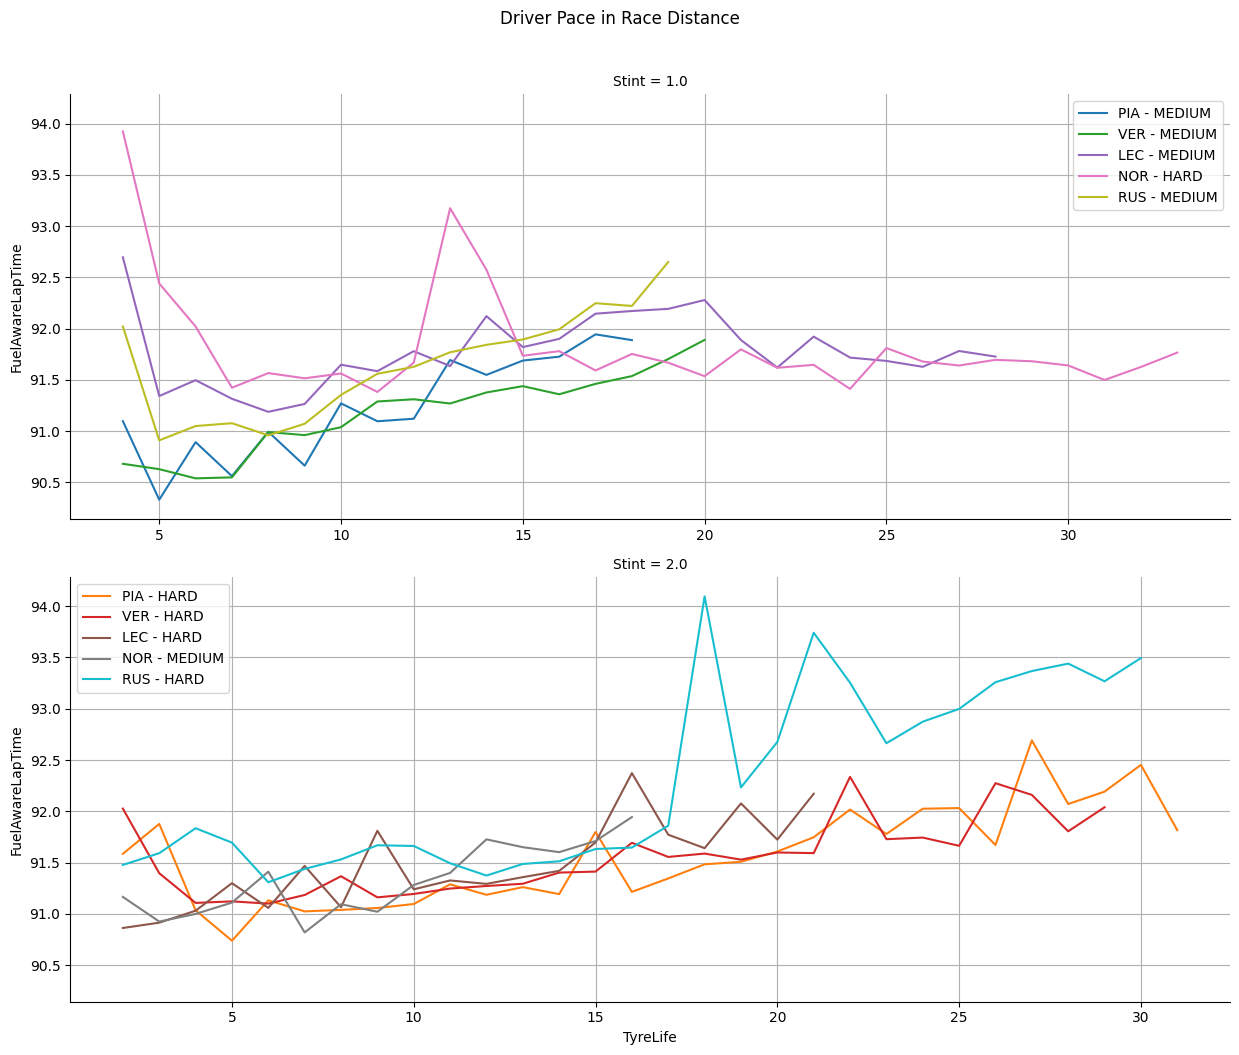

In [114]:
line_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    height=5,
    aspect=2.5,
    sharex=False
)

line_grid.map_dataframe(
    sns.lineplot,
    x="TyreLife",
    y="FuelAwareLapTime"
)

for ax in line_grid.axes.flatten():
    ax.legend()
    ax.grid()

line_grid.figure.suptitle("Driver Pace in Race Distance", y=1.05)
plt.show()

**Inference**
- Stint - 1:
*Note: Leclerc needs to be analysed further as he went long on a medium with good pace.*
    - `Verstappen`: by far has the best tyre deg on the Mediums of the top 5 where 3 other drivers including himself were on the same tyre.
    - `Piastri` and `Leclerc`: Piastri on similar strategy as Max had the second best tyre deg, while Leclerc also had amazing tyre deg considering he went atleast 8 laps longer that max on the same tyre.
    - `Russel`: Had the worst tyre deg of the medium strategy bunch having pushed harder / poor tyre management / dirty air earlier in the stint.
    - `Norris`: On the opposite strategy went longer on the hards which took their time to get into the tyre window thus the average time lost earlier in the stint is massive since the laptime are slower that Russel. Further might have been a mistake lap 13 identified by the spike however, hards have good durability so he was able to pull it back later in the stint by lapping the best pace of the mediums for 20 laps before stint 2.

- Stint - 2:
*Note: Overall there doesn't seem to be much distinction between the mediums (NOR) and hards of the rest during the second stint could be attributed to better track evolution and provisionally the drivers on hards bringing the tyre's to their operating window fast and well.*
    - `Verstappen` and `Piastri`: Both drivers have identical pace throughout the stint however, Piastri seems to have pushed / reached the window earlier since he pitted first during the first stint. However, Piastri pace is spiky during the stint prospectivly overtakes (from traffic or track position). Verstappen has a smoother curve indicating sustained pace for longer with spikes towards the end of the stint, provisonally overtakes (from traffic or track position).
    - `Leclerc`: Having pitted later he had a stonking out lap to push the hards to the operating window quicker than others since he had lesser distance to cover on them. He has spikes which should definitely be overtakes for position due to the strategy he was on but the pace is really good inline with VER and PIA.
    - `Russel`: Seems to have the worst pace on the hard both getting them into the window and then utilising the grip later into the stint with maybe mistakes or traffic later in the stint (large spikes and increased slope towards the end of the stint).
    - `Norris`: On the opposite startegy go into the operating window quickly too but LEC was still better. Norris was mostly inline in pace with the hard runners with minor spikes for overtaking traffic or gaining track position with ease. Having pitted last in the first stint he was in good pace with the Medium front runners but the tyre gains were marginal.


**Quantifying the Tyre degradation by Stint (for the Front Runners)**

In [ ]:
def tyredeg_coeff(tyre_life: pd.Series, fuel_aware_laptime: pd.Series) -> np.ndarray:
    """Calculates the linear polynomial coefficients for tyre
    degradation for each driver wrt each stint during the race and returns them."""

    coeffs = np.polyfit(
        x=tyre_life,
        y=fuel_aware_laptime,
        deg=2
    )

    return coeffs[:2]

driver_deg_coeffs = filtered_quick_race_laps.groupby(["Driver", "Stint"])[["TyreLife", "FuelAwareLapTime"]].apply(  # type: ignore
    lambda x: tyredeg_coeff(tyre_life=x.TyreLife, fuel_aware_laptime=x.FuelAwareLapTime)  # type: ignore
)
driver_deg_coeffs

Driver  Stint
LEC     1.0      [-0.0014705665308654722, 0.05637556077847401]
        2.0      [0.0001830633350650536, 0.054109900074252905]
NOR     1.0       [0.002078805342992342, -0.10090786748203875]
        2.0      [0.006109278577764663, -0.046986746154046174]
PIA     1.0      [0.00453532862999425, -0.0017092836598715303]
        2.0      [0.001956608753909125, -0.023758940031659407]
RUS     1.0       [0.010538787535293847, -0.15472142970940425]
        2.0       [0.002205993733057592, 0.014447534253284943]
VER     1.0      [-0.0006902744963877138, 0.09326815325055494]
        2.0      [0.001977712672190697, -0.030796465320452472]
Name: (TyreLife, FuelAwareLapTime), dtype: object

**Driver-Wise degradation in Race-Distance**

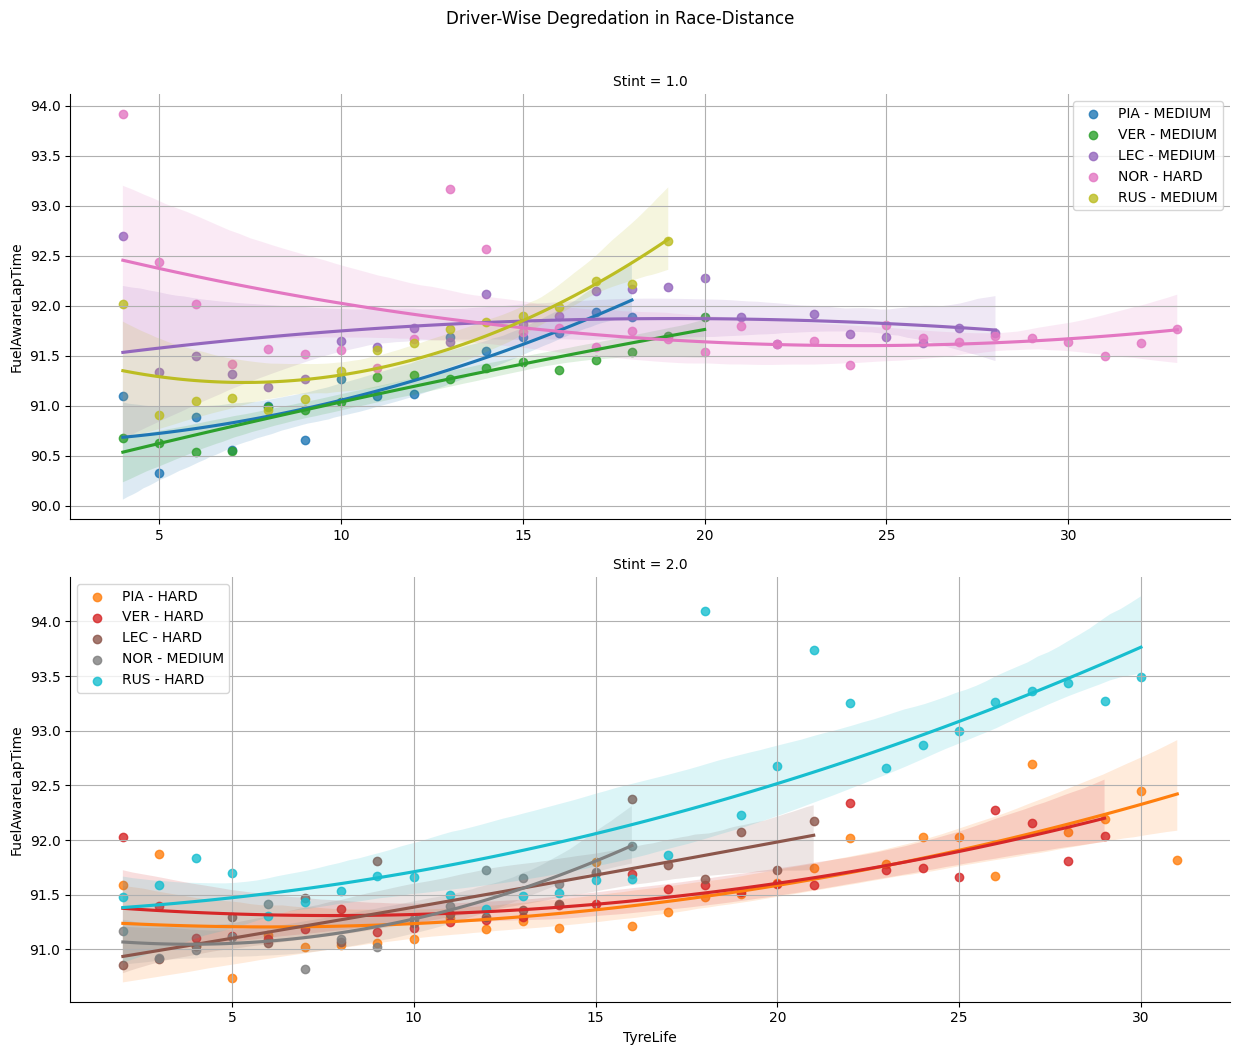

In [ ]:
degradation_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    sharex=False,
    sharey=False,
    height=5,
    aspect=2.5
)

degradation_grid.map_dataframe(
    sns.regplot,
    x="TyreLife",
    y="FuelAwareLapTime",
    order=2
)

for ax in degradation_grid.axes.flatten():
    ax.legend()
    ax.grid()

degradation_grid.figure.suptitle("Driver-Wise degradation in Race-Distance", y=1.05)
plt.show()

**Inference**
- The above tyre degradation graphs are thus inline with the manually calculated coefficients of degradation.
- Further the plots for each of the stints and drivers are mostly inline with the original hypothesis as derived from the lap-level pace for each of the drivers.

## Understanding Tyre degradation with respect to Car Setup and Track Layout
- While outright laptime is a significant driver to the tyre-degradation and hence the strategy of the race, the must still endure the race-distance with its locked race-trim.
- Thus, during a race the setup enables a car to push more in different track characteristics i.e; slow, medium and high speed sections.
- A combination such characteristics forms a sector of the track which we will use to diagnose tyre degradation further.

**Key Assumption**
- I have not accounted for the fuel burn correction over each sector as my assumption in the above lap-level analysis were already aggressive.

### Understanding the Track Layout
>Source: F1

<img src="../../assets/Saudi_Arabia_Circuit.png" alt="Image of the Jeddah Track Layout">

### Sector - 1
- As per the track layout Sector - 1 is illustrated by the `Red Path` turns 1 through 12.
- At a high-level this sector comprises of slow and medium speed corners with short straights.

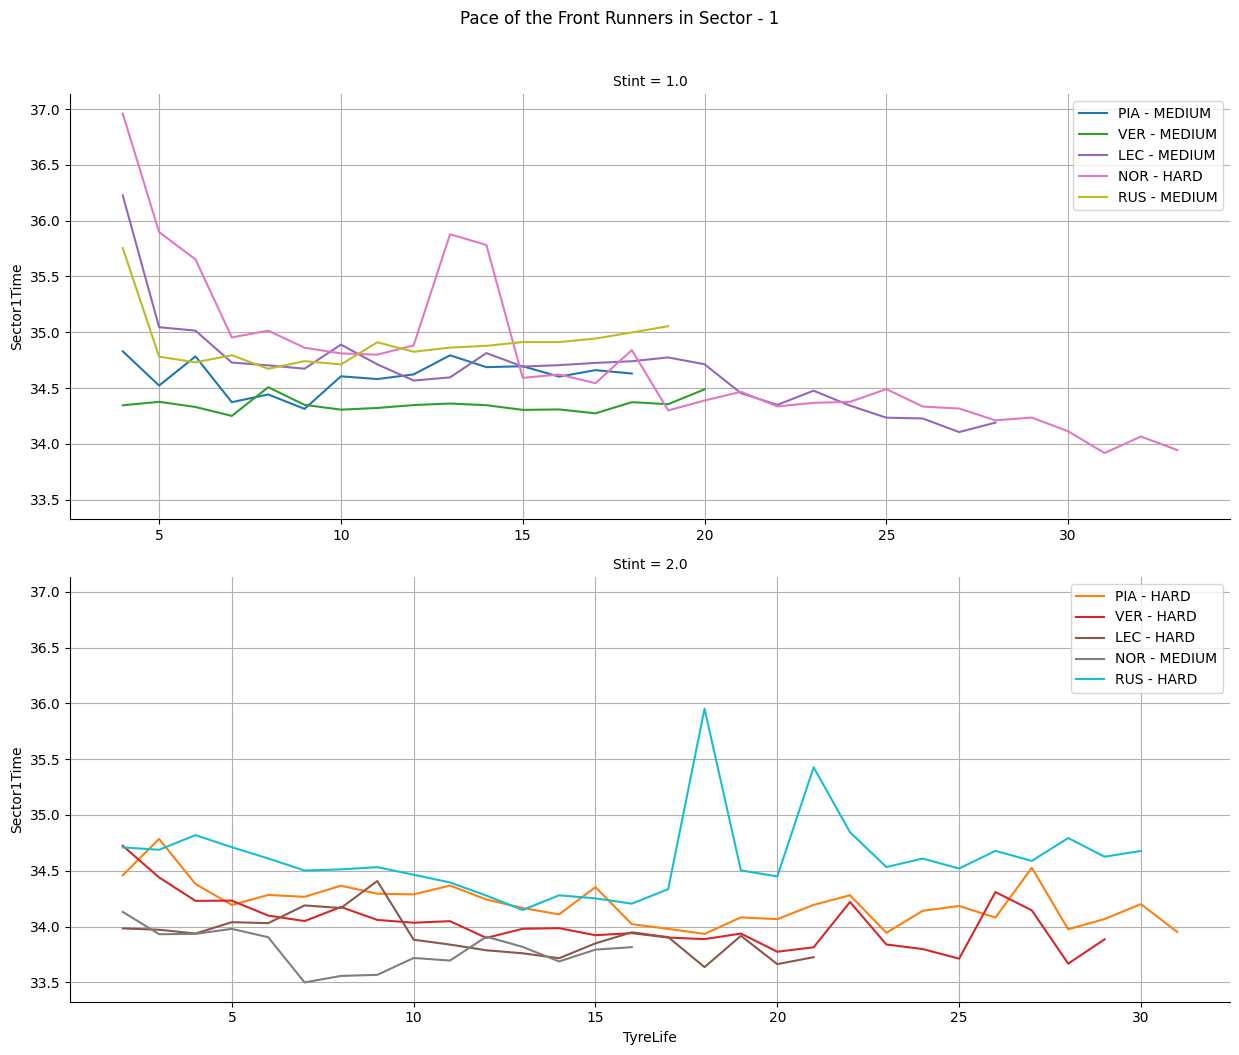

In [117]:
line_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    height=5,
    aspect=2.5,
    sharex=False
)

line_grid.map_dataframe(
    sns.lineplot,
    x="TyreLife",
    y="Sector1Time",
)

for ax in line_grid.axes.flatten():
    ax.legend()
    ax.grid()

line_grid.figure.suptitle("Pace of the Front Runners in Sector - 1", y=1.05)
plt.show()

**Inference**

*General Notes*: 
- The performance for all the top runners in race-trim looks comparable.
- However, track evolution seems very evident in the second stint reducing the need for tyre management allowing all the drivers irrespective of the compound to push harder quickly to get into their operating windows.


- Stint - 1:
    - `Verstappen` showed amazing consistency while `Leclerc` showed amazing tyre management through the stint.
    - `Leclerc's` amazing tyre management meant he was able to lap with `Norris` who was on hards that were in within the window (ablation below).
    - `Norris` lost time between laps 12 through 15 batteling `Hamilton` for position on track (*Could have added to the tyre wear at the end in pace vs Charles*).
    - `Piastri` had the second best consistency after `Verstappen` while `Russel` had the worst pace on Mediums.
    - Plausible loss of setup performance for the Mercedes in Sector - 1: Slow to Medium Speed corners.

- Stint - 2:
    - `Piastri`, `Leclerc` and `Verstappen` all had amazing pace and consistency right from the outlap. However, in the case of `Leclerc` on the longer strategy with Hards much later in the race the out lap was perfect.
    - `Norris` was the fastest in the second stint due to his opposite strategy with much quick Mediums towards the end.
    - `Russel` also on the hards while consistent lack the pace of the front runners even with track evolution. Further, he lost time batteling `Leclerc` indicated by the spike.
    

In [118]:
# Cols to inform battle params
battle_cols = ["LapNumber", "Driver", "DriverNumber", "LapTime", "Stint", "Sector1Time", "SpeedI1", "Sector2Time", "SpeedI2", "Sector3Time", "SpeedST", "TyreLife", "Position", "Compound"]

# Hamilton Vs Norris - Stint 1
race_laps[
    (race_laps["LapNumber"] >= 11) & 
    (race_laps["LapNumber"] <= 16) & 
    ((race_laps["Position"] == 6.0) | (race_laps["Position"] == 7.0))
][battle_cols]

,LapNumber,Driver,DriverNumber,LapTime,Stint,Sector1Time,SpeedI1,Sector2Time,SpeedI2,Sector3Time,SpeedST,TyreLife,Position,Compound
160,11.0,NOR,4,94.088,1.0,34.799,291.0,29.494,306.0,29.795,313.0,11.0,7.0,HARD
161,12.0,NOR,4,94.311,1.0,34.882,290.0,29.515,319.0,29.914,319.0,12.0,6.0,HARD
162,13.0,NOR,4,95.754,1.0,35.878,NaN,29.550,315.0,30.326,329.0,13.0,6.0,HARD
163,14.0,NOR,4,95.090,1.0,35.782,287.0,29.647,317.0,29.661,327.0,14.0,7.0,HARD
164,15.0,NOR,4,94.188,1.0,34.591,285.0,29.752,304.0,29.845,306.0,15.0,6.0,HARD
165,16.0,NOR,4,94.170,1.0,34.621,287.0,29.739,302.0,29.810,306.0,16.0,6.0,HARD
310,11.0,HAM,44,94.456,1.0,34.828,290.0,29.649,311.0,29.979,316.0,11.0,6.0,MEDIUM
311,12.0,HAM,44,95.310,1.0,34.871,289.0,29.816,310.0,30.623,315.0,12.0,7.0,MEDIUM
312,13.0,HAM,44,95.679,1.0,35.138,NaN,29.701,309.0,30.840,316.0,13.0,7.0,MEDIUM
313,14.0,HAM,44,94.818,1.0,35.001,288.0,29.753,308.0,30.064,313.0,14.0,6.0,MEDIUM


In [119]:
# Russel Vs Leclerc - Stint 2
race_laps[
    (race_laps["LapNumber"] >= 35) & 
    (race_laps["LapNumber"] <= 40) & 
    ((race_laps["Position"] == 3.0) | (race_laps["Position"] == 4.0))
][battle_cols]

,LapNumber,Driver,DriverNumber,LapTime,Stint,Sector1Time,SpeedI1,Sector2Time,SpeedI2,Sector3Time,SpeedST,TyreLife,Position,Compound
134,35.0,LEC,16,92.390,2.0,34.030,293.0,29.051,313.0,29.309,318.0,6.0,4.0,HARD
135,36.0,LEC,16,92.738,2.0,34.189,292.0,29.044,310.0,29.505,314.0,7.0,4.0,HARD
136,37.0,LEC,16,92.273,2.0,34.166,291.0,28.994,324.0,29.113,329.0,8.0,4.0,HARD
137,38.0,LEC,16,92.957,2.0,34.408,292.0,29.178,307.0,29.371,310.0,9.0,3.0,HARD
138,39.0,LEC,16,92.324,2.0,33.882,NaN,29.159,306.0,29.283,310.0,10.0,3.0,HARD
139,40.0,LEC,16,92.349,2.0,33.838,293.0,29.071,308.0,29.440,311.0,11.0,3.0,HARD
234,35.0,RUS,63,92.966,2.0,34.252,291.0,29.099,308.0,29.615,313.0,15.0,3.0,HARD
235,36.0,RUS,63,92.918,2.0,34.205,292.0,29.038,312.0,29.675,315.0,16.0,3.0,HARD
236,37.0,RUS,63,93.069,2.0,34.335,NaN,29.121,310.0,29.613,316.0,17.0,3.0,HARD
237,38.0,RUS,63,95.244,2.0,35.952,287.0,29.415,310.0,29.877,314.0,18.0,4.0,HARD


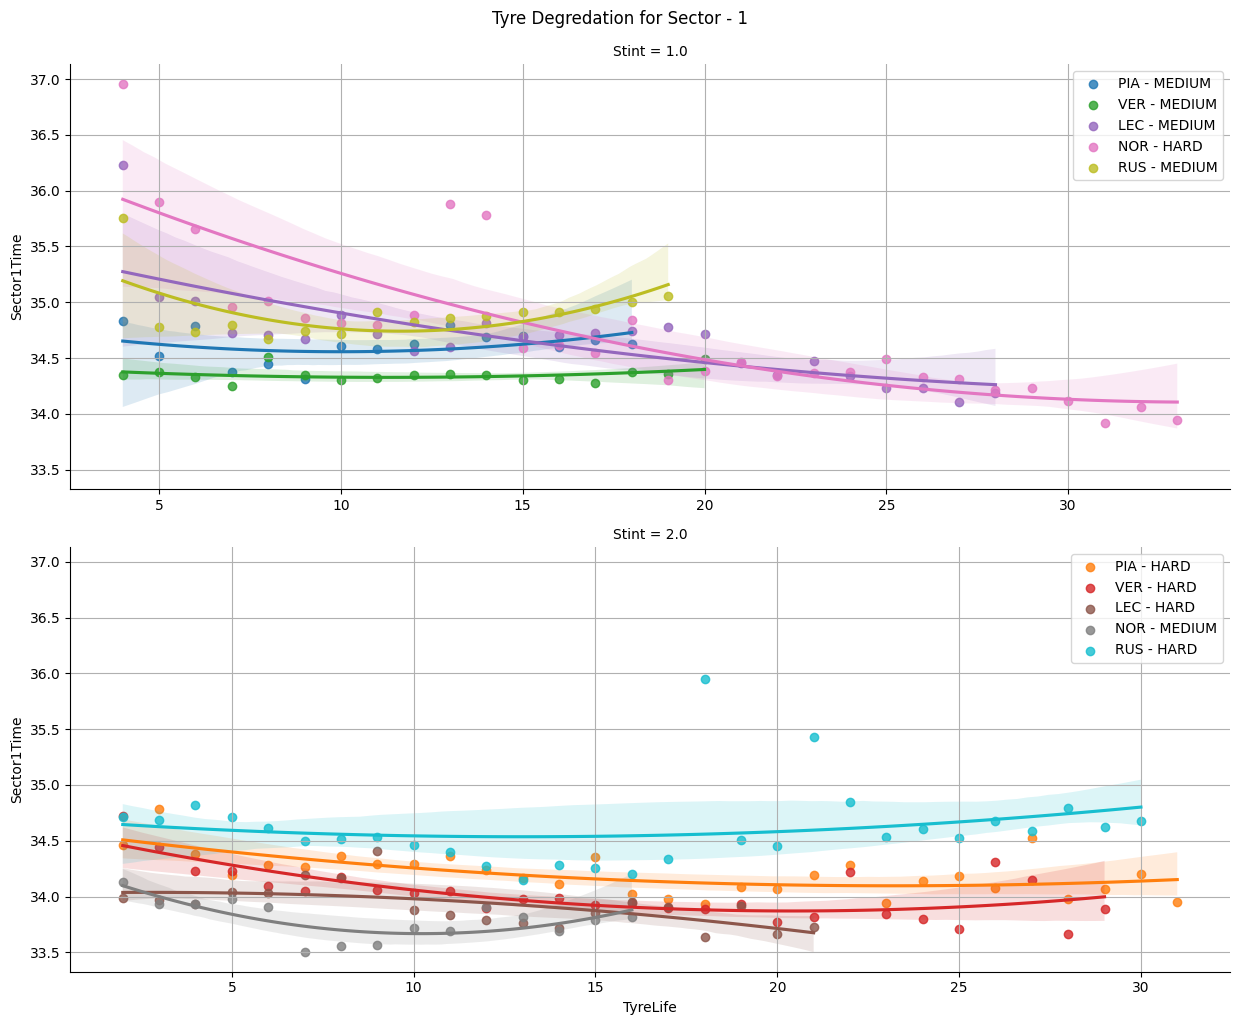

In [ ]:
degradation_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    height=5,
    aspect=2.5,
    sharex=False
)

degradation_grid.map_dataframe(
    sns.regplot,
    x="TyreLife",
    y="Sector1Time",
    order=2
)

for ax in degradation_grid.axes.flatten():
    ax.legend()
    ax.grid()

degradation_grid.figure.suptitle("Tyre degradation for Sector - 1", y=1.02)
plt.show()

In [121]:
driver_deg_coeffs = filtered_quick_race_laps.groupby(["Driver", "Stint"])[["TyreLife", "Sector1Time"]].apply(  # type: ignore
    lambda x: tyredeg_coeff(tyre_life=x.TyreLife, fuel_aware_laptime=x.Sector1Time)  # type: ignore
)
driver_deg_coeffs

Driver  Stint
LEC     1.0       [0.0010864548494985164, -0.07697963210702602]
        2.0      [-0.0010809409888356777, 0.005826304397355218]
NOR     1.0       [0.0020876718178929874, -0.13990659363578822]
        2.0           [0.006361102133161085, -0.13005340982547]
PIA     1.0       [0.0026735617323851582, -0.05335407239818928]
        2.0       [0.0009154765215318268, -0.04248169295248637]
RUS     1.0        [0.007725315126050377, -0.17994842436974612]
        2.0       [0.0009134841181559695, -0.02364922577113973]
VER     1.0      [0.0009268575851392837, -0.020874484004127662]
        2.0         [0.001727348322175965, -0.0705633973306399]
Name: (TyreLife, Sector1Time), dtype: object

### Sector - 2
- As per the track layout above sector - 2 is illustrated by the `Blue Path` turns 13 - 21.
- This section is mostly high-speed and my most favourite section of the track.
- Zooming through the corners at jaw dropping speeds between the wall is just fascinating.

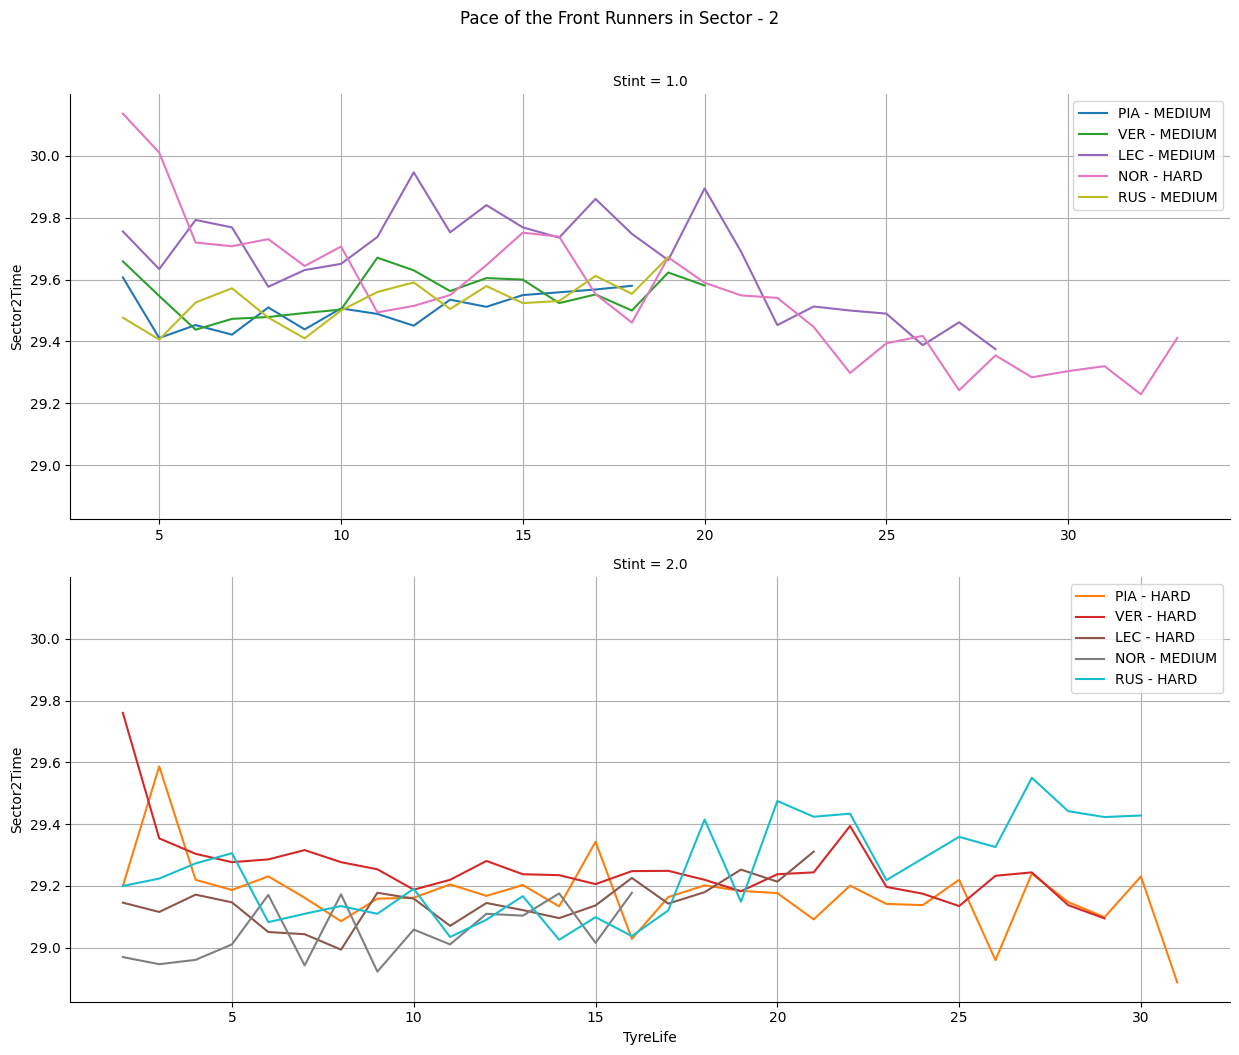

In [122]:
line_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    height=5,
    aspect=2.5,
    sharex=False
)

line_grid.map_dataframe(
    sns.lineplot,
    x="TyreLife",
    y="Sector2Time"
)

for ax in line_grid.axes.flatten():
    ax.legend()
    ax.grid()

line_grid.figure.suptitle("Pace of the Front Runners in Sector - 2", y=1.05)
plt.show()

**Inference**
- Stint - 1
    - We can see a clear difference in the pace in the tyre-critical high-speed section that is sector 2.
    - `Norris` with the opposite strategy took his to bring the Hards into the operating window and had consistent grip throughout the rest of the stint allowing him to gain laptime.
    - `Leclerc` with the longer strategy appear to vastly manage his Mediums in the high-speed section saving tyre while also defending against low probability overtakes. This payed dividents for him later in the stint.
    - `Piastri`, `Verstappen` and `Russel` all of them fared well in the high speed section with little difference in pace and tyre degradation. However, `Piastri` was the best among the lot in managing the pace in the Mediums.
- Stint - 2
    - `Piastri` displayed execeptional performance in the sector with hard tyre gain time every lap since the intial outlaps brings the Hards into their working window.
    - `Russel` seemed to have pushed alot earlier in the stint to match the pace of `Piastri` however, he lost grip quickly and thus track position later in the stint. While `Verstappen` wasn't any impressive on the Hards.
    - Plausible weakness of the Redbull in High-Speed section.
    - `Norris` had the fastest pace for this sector in the stint however, this was massively due to the aggressive strategy. On a similar strategy `Leclerc` fired up the Hards quickly and set a good amount of laps at near quali pace for the high-speed sector makeup time given his tyre offset.

In [123]:
# Leclerc's tyre management
race_laps[
    (race_laps["Driver"] == "LEC") & 
    (race_laps["LapNumber"] > 8) & 
    (race_laps["LapNumber"] < 25)
][battle_cols]

,LapNumber,Driver,DriverNumber,LapTime,Stint,Sector1Time,SpeedI1,Sector2Time,SpeedI2,Sector3Time,SpeedST,TyreLife,Position,Compound
108,9.0,LEC,16,94.099,1.0,34.673,291.0,29.631,311.0,29.795,318.0,9.0,4.0,MEDIUM
109,10.0,LEC,16,94.419,1.0,34.889,288.0,29.651,309.0,29.879,313.0,10.0,4.0,MEDIUM
110,11.0,LEC,16,94.293,1.0,34.712,289.0,29.738,311.0,29.843,316.0,11.0,4.0,MEDIUM
111,12.0,LEC,16,94.425,1.0,34.567,NaN,29.947,307.0,29.911,313.0,12.0,4.0,MEDIUM
112,13.0,LEC,16,94.217,1.0,34.595,NaN,29.753,310.0,29.869,317.0,13.0,4.0,MEDIUM
113,14.0,LEC,16,94.641,1.0,34.813,288.0,29.841,308.0,29.987,313.0,14.0,4.0,MEDIUM
114,15.0,LEC,16,94.276,1.0,34.692,289.0,29.769,309.0,29.815,314.0,15.0,4.0,MEDIUM
115,16.0,LEC,16,94.293,1.0,34.705,NaN,29.736,310.0,29.852,314.0,16.0,4.0,MEDIUM
116,17.0,LEC,16,94.476,1.0,34.725,NaN,29.861,309.0,29.890,314.0,17.0,4.0,MEDIUM
117,18.0,LEC,16,94.439,1.0,34.740,287.0,29.748,308.0,29.951,314.0,18.0,4.0,MEDIUM


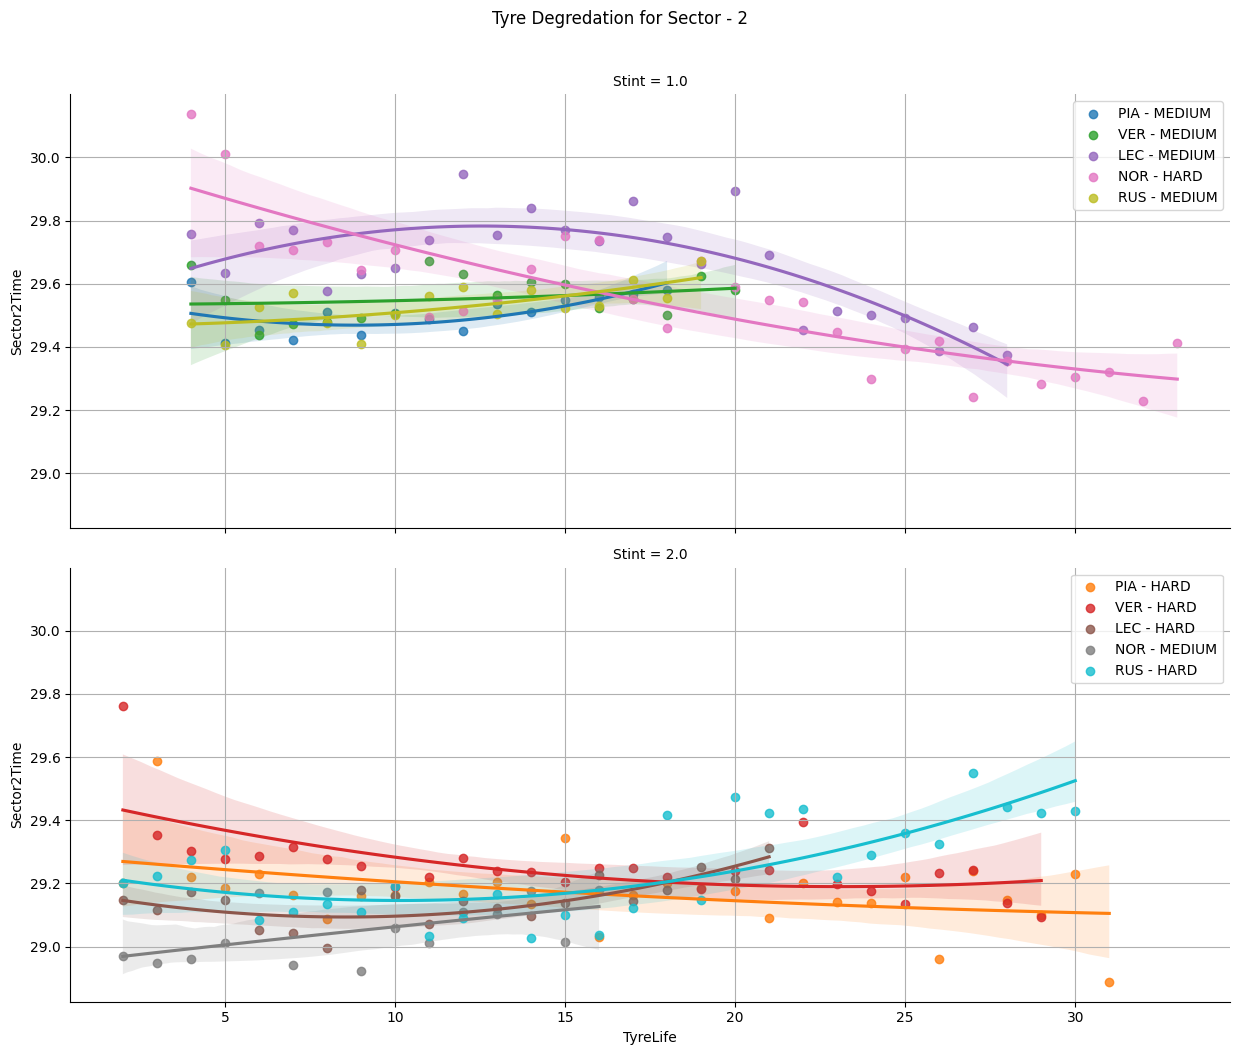

In [ ]:
degradation_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    height=5,
    aspect=2.5
)

degradation_grid.map_dataframe(
    sns.regplot,
    x="TyreLife",
    y="Sector2Time",
    order=2
)

for ax in degradation_grid.axes.flatten():
    ax.legend()
    ax.grid()

degradation_grid.figure.suptitle("Tyre degradation for Sector - 2", y=1.05)
plt.show()

In [125]:
driver_deg_coeffs = filtered_quick_race_laps.groupby(["Driver", "Stint"])[["TyreLife", "Sector2Time"]].apply(  # type: ignore
    lambda x: tyredeg_coeff(tyre_life=x.TyreLife, fuel_aware_laptime=x.Sector2Time)  # type: ignore
)
driver_deg_coeffs

Driver  Stint
LEC     1.0         [-0.0018348940914157885, 0.04605353400223043]
        2.0        [0.0012278992936888729, -0.020986796536798375]
NOR     1.0        [0.00038972866677264333, -0.03525043897981928]
        2.0        [-7.126696832598583e-05, 0.012554234001295583]
PIA     1.0        [0.0015938106011635059, -0.028145976082740828]
        2.0       [0.00011225766724939184, -0.009372133720007027]
RUS     1.0      [0.0004269957983194499, -2.5315126051064122e-05]
        2.0        [0.0009625509825731797, -0.019549414693574112]
VER     1.0      [0.00013738390092870106, -0.0001722136222906857]
        2.0         [0.0005464927792513952, -0.02521139109932173]
Name: (TyreLife, Sector2Time), dtype: object

### Sector - 3
- As per the track layout above sector - 3 is illustrated by the `Yellow Path` turns 22 - 27.
- This section is mostly high-speed and long straights before a crucial breaking zone into turn 27.

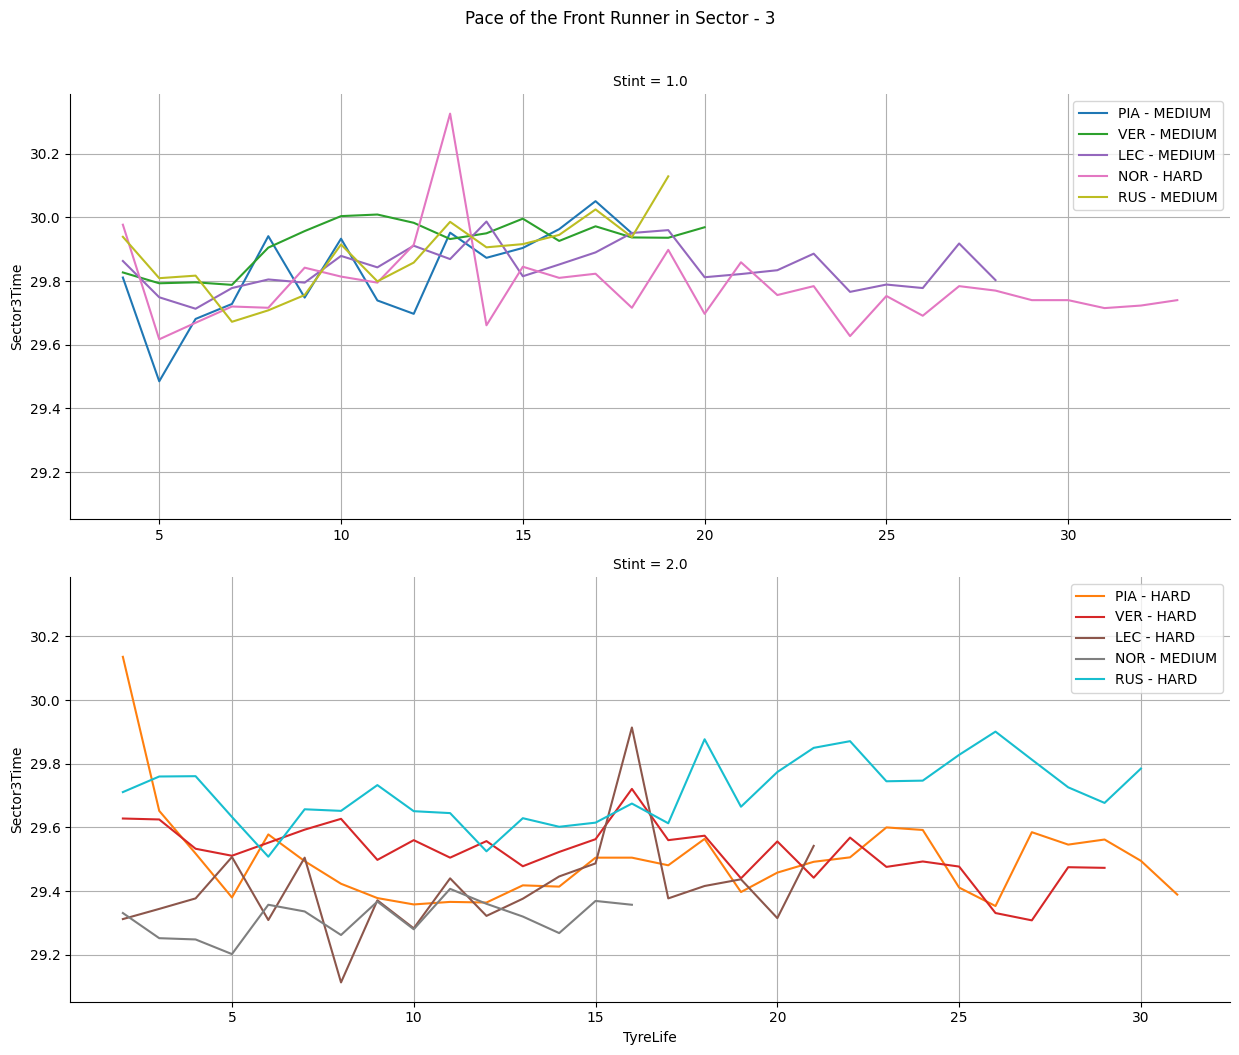

In [126]:
line_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    height=5,
    aspect=2.5,
    sharex=False
)

line_grid.map_dataframe(
    sns.lineplot,
    x="TyreLife",
    y="Sector3Time"
)

for ax in line_grid.axes.flatten():
    ax.legend()
    ax.grid()

line_grid.figure.suptitle("Pace of the Front Runner in Sector - 3", y=1.05)
plt.show()

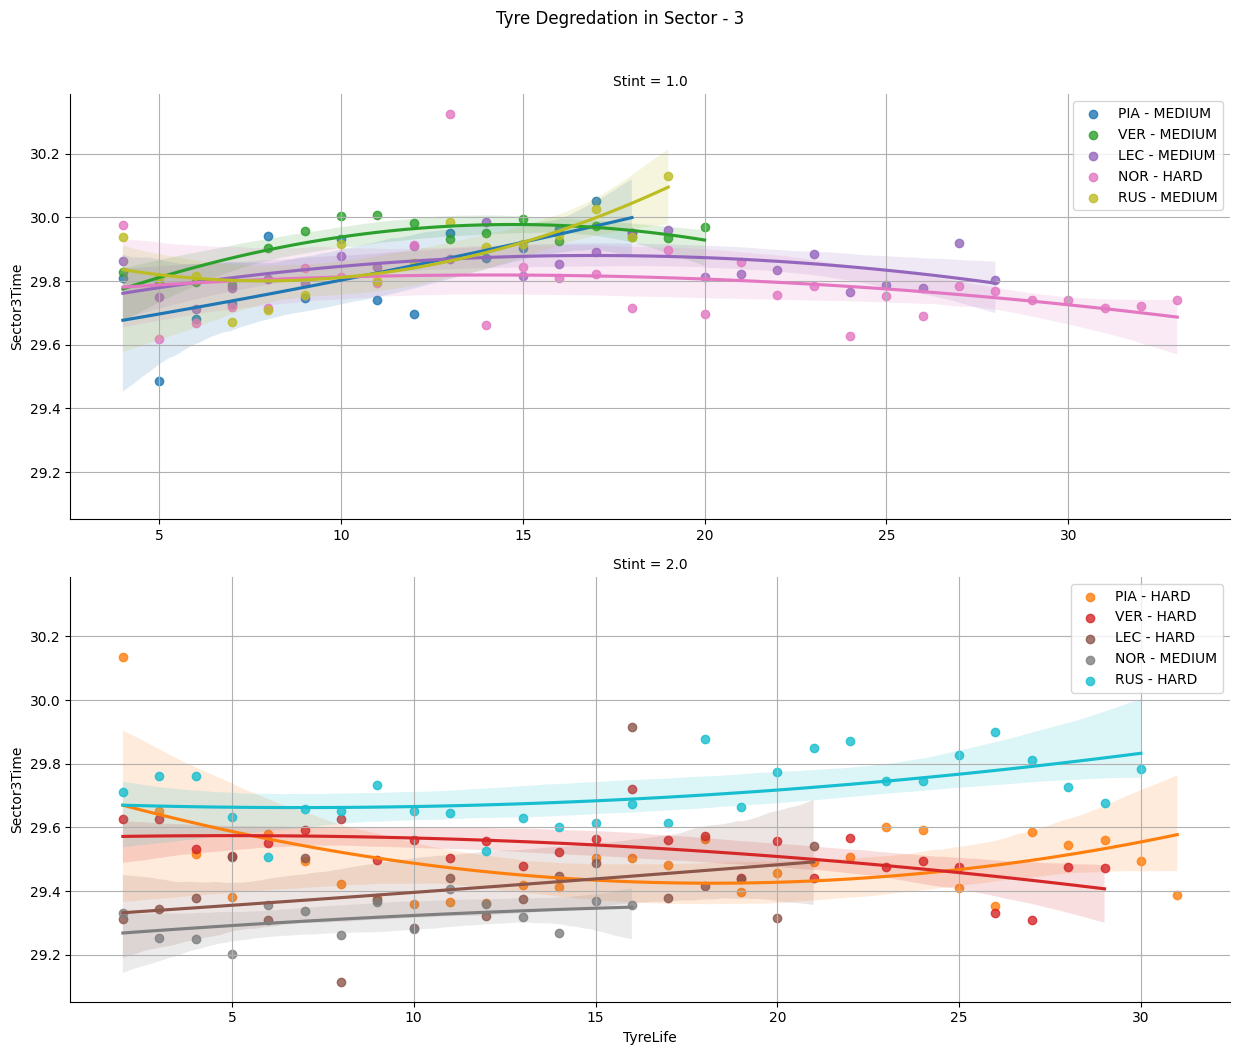

In [ ]:
degradation_grid = sns.FacetGrid(
    data=filtered_quick_race_laps,
    row="Stint",
    hue="DriverCompoundForStint",
    height=5,
    aspect=2.5,
    sharex=False
)

degradation_grid.map_dataframe(
    sns.regplot,
    x="TyreLife",
    y="Sector3Time",
    order=2
)

for ax in degradation_grid.axes.flatten():
    ax.legend()
    ax.grid()

degradation_grid.figure.suptitle("Tyre degradation in Sector - 3", y=1.05)
plt.show()

**Inference**
- Unlike the other sectors with various unique corners and characteristics, this sector is a comparable for the front runners across the various manufacturers.
- This is mostly due to the simplicity of the sector and the dominance of long straights with one crucial breaking zone; the final corner.
- Thus for `Leclerc` we see the importance of saving in sector 2 through his race result, while using both sector 1 and 3 to ensure defensive positioning from key overtaking points into turn 1 and into turn 27.

## The Role of Weather in F1 and Tyres degradation
- Alot of my understanding below is derived from this amazing [blog post](https://www.catapult.com/blog/race-strategy-f1-track-surface)

**Key Pointers**
- Track Temperature: Directly affects the tyre performance and thereby the degradation.
- Air Temperature (Ambient Temp): Directly affects the performance of the driver and the mechanical performance of the car such as Cooling, Aerodynamic Efficiency.
- Humidity: Affects the tyre degradation indirectly by interacting with the grip (frictional force) available on track.
- I have decided to omit wind-speed and direction as they are very noisy for analysis.

In [128]:
# Loading the weather data for the race session
jeddah_race_weather = jeddah_race.weather_data.copy()  # type: ignore
jeddah_race_weather

,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:02.318000,28.7,71.0,1006.3,False,39.4,315,1.2
1,0 days 00:01:02.315000,28.7,71.0,1006.3,False,39.4,284,1.4
2,0 days 00:02:02.314000,28.7,70.0,1006.4,False,39.4,261,0.9
3,0 days 00:03:02.328000,28.7,71.0,1006.3,False,39.4,265,0.9
4,0 days 00:04:02.323000,28.7,70.0,1006.3,False,39.2,283,1.8
...,...,...,...,...,...,...,...,...
137,0 days 02:17:02.547000,31.6,48.0,1007.3,False,36.0,0,0.3
138,0 days 02:18:02.550000,31.6,48.0,1007.2,False,35.9,153,0.4
139,0 days 02:19:02.548000,31.6,48.0,1007.2,False,36.0,267,1.1
140,0 days 02:20:02.557000,31.6,48.0,1007.2,False,36.2,275,0.5


In [129]:
# Merging the Race Data and Weather Data on uniform Session Time
weather_aware_race_df = pd.DataFrame()

# Helper function
def merge_laps_to_weather_by_driver(driver_data: pd.DataFrame, weather_aware_race_df: pd.DataFrame = weather_aware_race_df) -> pd.DataFrame:
    merged_df = pd.merge_asof(
        left=driver_data,
        right=jeddah_race_weather,
        on="Time"
    )

    weather_aware_race_df = pd.concat([weather_aware_race_df, merged_df], axis=0)
    return weather_aware_race_df

grouped_df = filtered_quick_race_laps.groupby("Driver")
for driver, driver_data in grouped_df:
    weather_aware_race_df = merge_laps_to_weather_by_driver(driver_data, weather_aware_race_df=weather_aware_race_df)

weather_aware_race_df = weather_aware_race_df.reset_index()
weather_aware_race_df

,index,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,...,CumulativeFuelBurnt,FuelAwareLapTime,DriverCompoundForStint,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0,0 days 01:06:17.488000,LEC,16,95.845,4.0,1.0,NaT,NaT,36.226,...,2.131593,92.695000,LEC - MEDIUM,28.9,67.0,1006.7,False,38.1,158,0.4
1,1,0 days 01:07:51.916000,LEC,16,94.428,5.0,1.0,NaT,NaT,35.045,...,4.231672,91.341948,LEC - MEDIUM,28.9,67.0,1006.7,False,38.3,0,1.2
2,2,0 days 01:09:26.436000,LEC,16,94.520,6.0,1.0,NaT,NaT,35.014,...,6.333796,91.496950,LEC - MEDIUM,28.9,66.0,1006.7,False,38.2,213,1.5
3,3,0 days 01:11:00.711000,LEC,16,94.275,7.0,1.0,NaT,NaT,34.728,...,8.430472,91.315014,LEC - MEDIUM,29.0,66.0,1006.7,False,38.2,258,0.9
4,4,0 days 01:12:34.796000,LEC,16,94.085,8.0,1.0,NaT,NaT,34.703,...,10.522923,91.187914,LEC - MEDIUM,29.1,65.0,1006.7,False,38.1,280,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,40,0 days 02:11:56.488000,VER,1,92.324,46.0,2.0,NaT,NaT,33.712,...,85.030081,91.663304,VER - HARD,31.6,47.0,1007.2,False,36.3,78,1.3
221,41,0 days 02:13:29.361000,VER,1,92.873,47.0,2.0,NaT,NaT,34.309,...,87.095576,92.273902,VER - HARD,31.6,47.0,1007.3,False,36.1,183,0.7
222,42,0 days 02:15:02.058000,VER,1,92.697,48.0,2.0,NaT,NaT,34.145,...,89.157158,92.159867,VER - HARD,31.6,48.0,1007.3,False,36.2,148,1.3
223,43,0 days 02:16:34.338000,VER,1,92.280,49.0,2.0,NaT,NaT,33.667,...,91.209465,91.804715,VER - HARD,31.6,48.0,1007.2,False,36.2,0,0.5


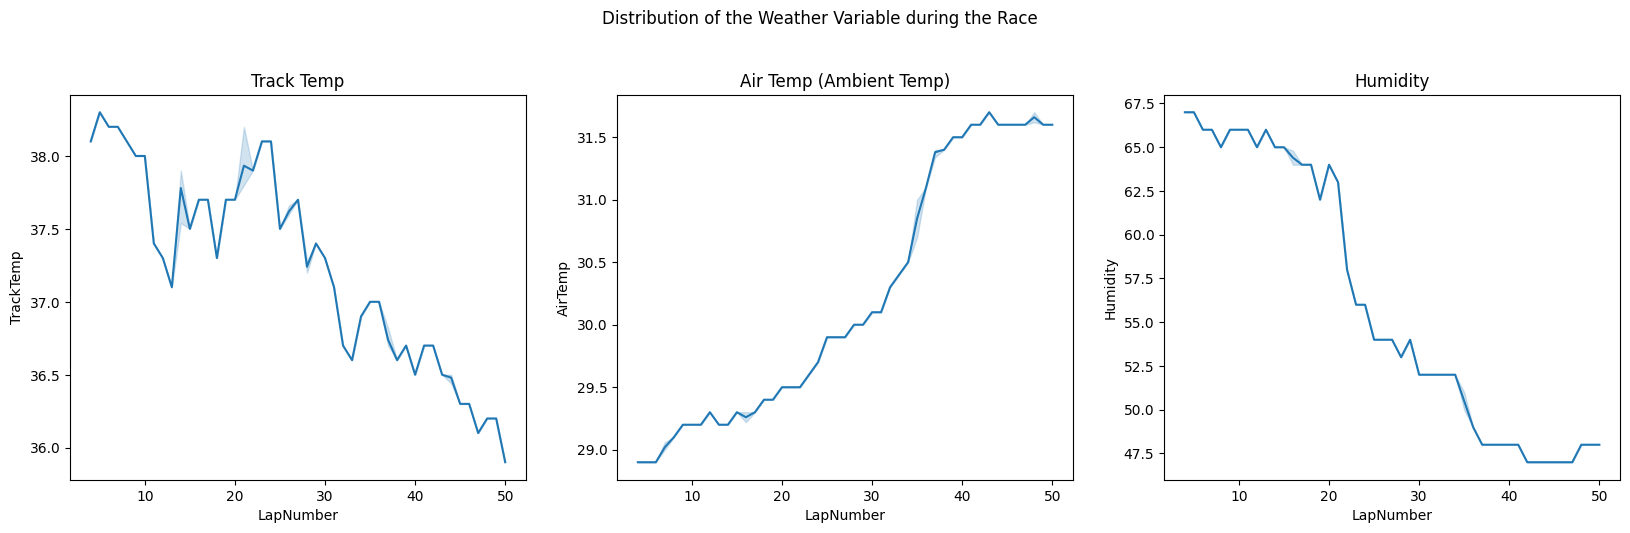

In [130]:
# Canvas for Weather Variable Grid
weather_grid, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# Track Temp
sns.lineplot(data=weather_aware_race_df, x="LapNumber", y="TrackTemp", ax=axes[0])
axes[0].set_title("Track Temp")

# Air Temp (Ambient Temp)
sns.lineplot(data=weather_aware_race_df, x="LapNumber", y="AirTemp", ax=axes[1])
axes[1].set_title("Air Temp (Ambient Temp)")

# Humidity
sns.lineplot(data=weather_aware_race_df, x="LapNumber", y="Humidity", ax=axes[2])
axes[2].set_title("Humidity")

weather_grid.suptitle("Distribution of the Weather Variable during the Race", y=1.05)
plt.show()

**Inference**
- By the above illustrated trends for the weather variables during the race session we can derive the following:
    - Track Temperature: is bi-polar in the first stint for all the drivers. The temperature falls from intial 38 degree C to 37 before rising back to 38 and then finally annelling to 36 degree C throughout the rest of the race.
    - Air Temperature: is constantly increasing through the race.
    - Humidity: is constantly decreasing through the race.
    
**Key Assumption**
- Due to the inverse nature of the trends in Humidity and Air Temperature it is safe to say their affects are mutually cancelled.
- Given that higher air temps can reduce aero efficiency while lower humidity can increase grip, their combined effect was assumed to be net neutral for this initial analysis.

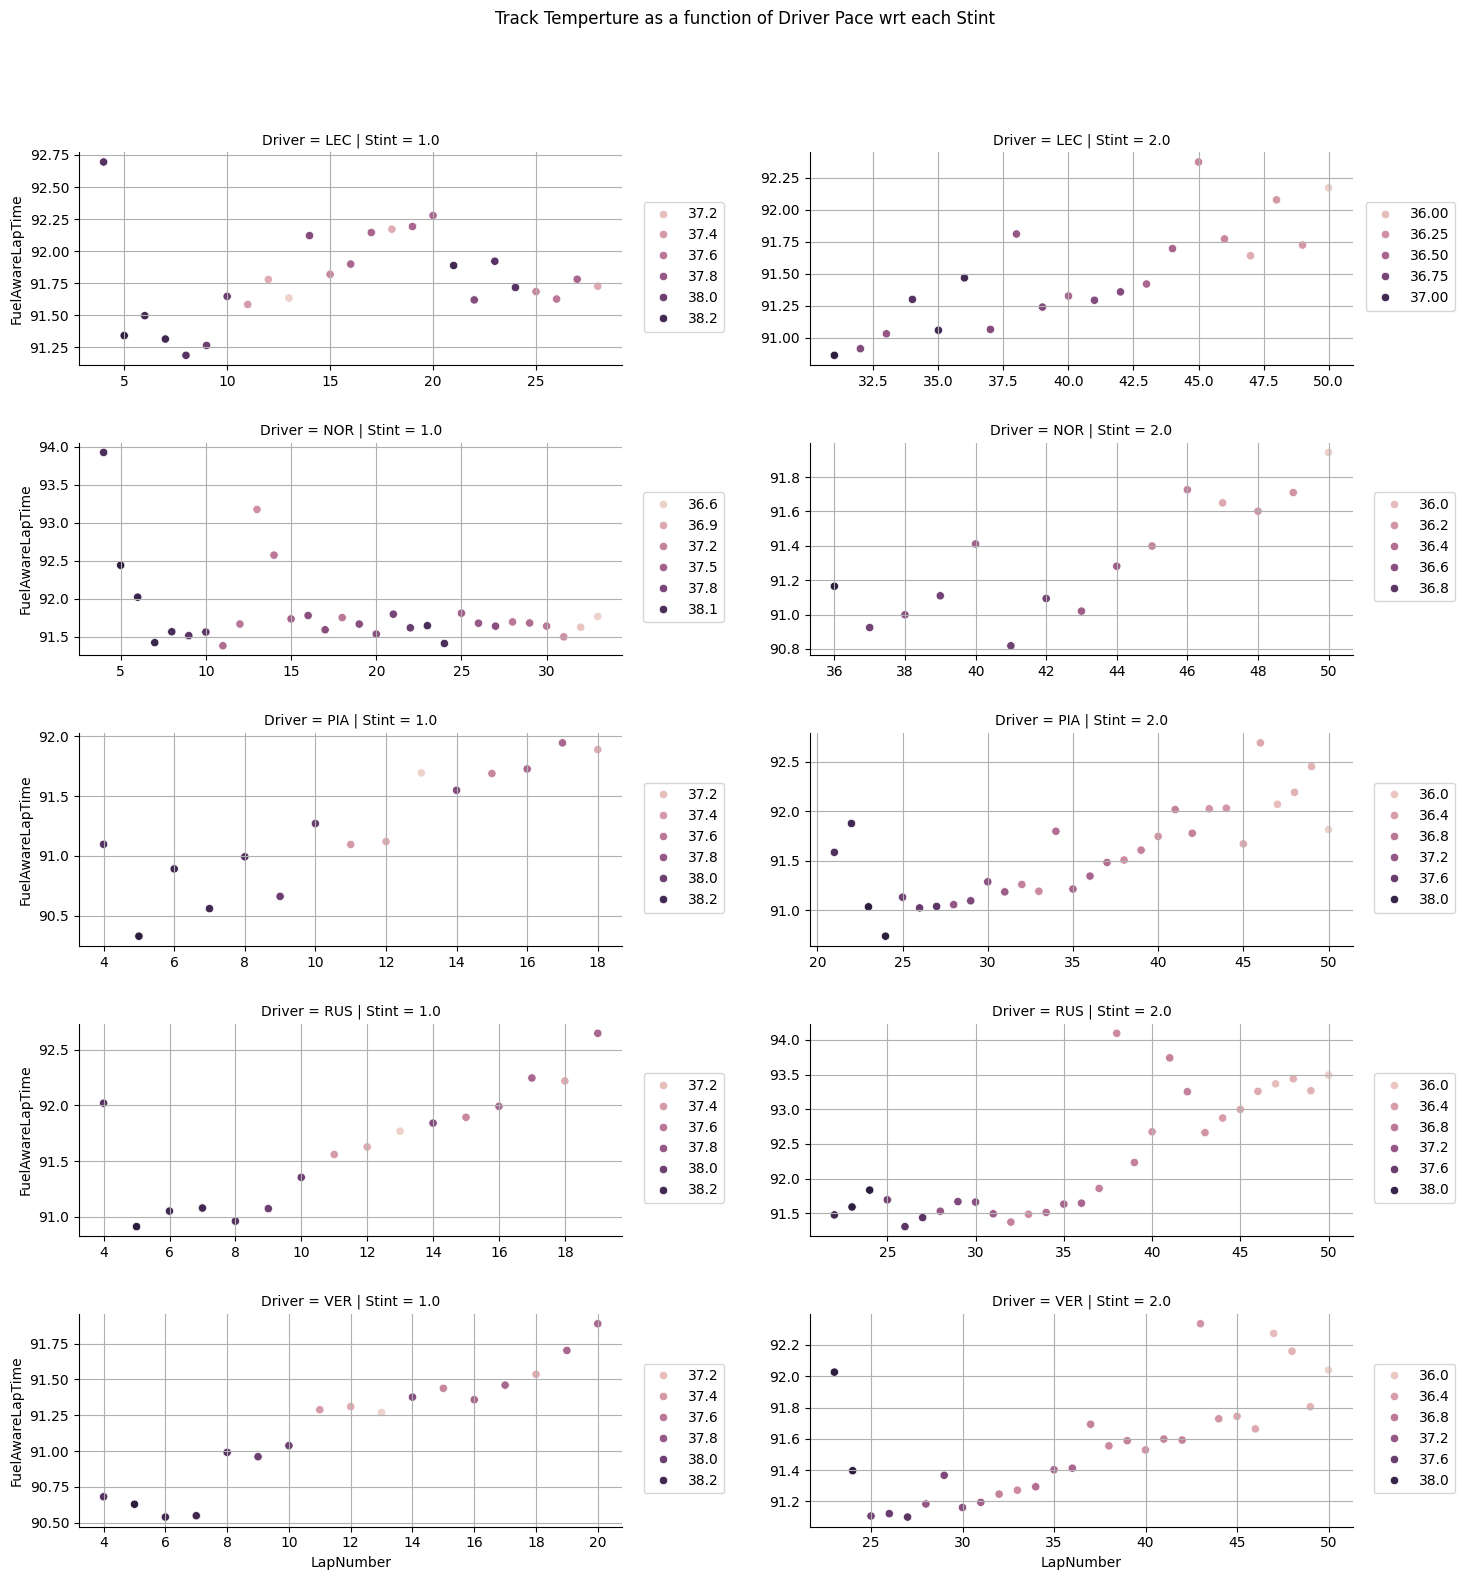

In [131]:
weather_grid = sns.FacetGrid(
    data=weather_aware_race_df,
    col="Stint",
    row="Driver",
    sharex=False,
    sharey=False,
    aspect=2.5
)

weather_grid.map_dataframe(
    sns.scatterplot,
    hue="TrackTemp",
    y="FuelAwareLapTime",
    x="LapNumber"
)

for ax in weather_grid.axes.flatten():
    ax.legend()
    sns.move_legend(obj=ax, loc="upper right", bbox_to_anchor=(1.2, 0.8))
    ax.grid()
    
weather_grid.figure.suptitle("Track Temperture as a function of Driver Pace wrt each Stint", y=1.05)
weather_grid.tight_layout(h_pad=2.5, w_pad=0.8)
plt.show()

**Inference**
- `Leclerc`: Due to the strategy that leclerc was on **(Going Longer on the Medium Tyres)** despite the bi-polar peak of Track Temp, his initial tyre coordination coupled with massive managment payed dividents. Thus his Mediums were able to work well in peaking heat and bring pace on latter laps when needed. However, switching to hards was a flaw provisionally in both execution (by Leclerc) and strategy (by Ferrari). I predict, with the need to push quickly on cold tyres `Leclerc` encountered graining causing irregular lap times in the second half of the second stint.
- `Norris`: On the opposite strategy **(Stint - 1 Hards)** he coordinated with the tyre well to bring it seemlessly into the window thus his laptimes seem largely invariant to temperature due to the endurance provided by the Hards for longer stints. However, much in similarity to Leclerc `Norris` was on pace since the outlap thus hurting his much sensitive Mediums which degraded quickly towards the end of the race.
- `Russel`, `Piastri` and `Verstappen` (Stint - 1): Since all the drivers were on the same startegy comparing their performance across the stints provides much better evidence of the affect of tracktemp on the tyres. Just from the pace graphs it feels like `Verstappen` was the best at working with the mediums, being able to sustain consistent pace through the temperature variations. However, collectively the mediums were sensitive for a long first stint and thus the degradation was very high towards the end.
- `Russel`, `Piastri` and `Verstappen` (Stint - 2): While the pace looks good in stint for `Russel` considering the weather, y-axis shows that he was consistently 0.2s ~ 0.3s per lap slower on the first half with Hards. While Piastri and Verstappen traded blows on pure pace with Hards. However while I cannot isolate the affect of weather both their styles meant the grip peaked at about lap 35 after which the pace was lost with degradation.

### Modelling the Weather and Pace Variables as Multivariate function of FuelAwareLapTime

In [ ]:
# Grouping the data by driver and stint
grouped_driver_df = weather_aware_race_df.groupby(["Driver", "Stint"])

# Generating the polynomial features for each driver
modelling_cols = ["TyreLife", "TrackTemp"]
interaction_cols = [
    "Driver", "DriverCompoundForStint", "Stint", "LapNumber", 
    "TyreLife", "TrackTemp", "TyreLife_Sq", "TyreLife_TrackTemp", 
    "TrackTemp_Sq", "FuelAwareLapTime"
]
poly_df = pd.DataFrame(columns=interaction_cols)

# Modelling the Polynomial Features
for driver_info, stint_data in grouped_driver_df:
    
    # Polynomial Feature Transformer
    poly_model = PolynomialFeatures(degree=2, include_bias=True)
    poly_feat = poly_model.fit_transform(X=stint_data[modelling_cols])

    # Concatenating the data for downstream modelling
    driver_df = pd.DataFrame(
        data=np.c_[
            stint_data[["Driver", "DriverCompoundForStint", "Stint", "LapNumber"]].to_numpy(), 
            poly_feat[:, 1:], 
            stint_data["FuelAwareLapTime"].to_numpy()
        ],
        columns=interaction_cols
    )
    poly_df = pd.concat([poly_df, driver_df], axis=0)

poly_df

,Driver,DriverCompoundForStint,Stint,LapNumber,TyreLife,TrackTemp,TyreLife_Sq,TyreLife_TrackTemp,TrackTemp_Sq,FuelAwareLapTime
0,LEC,LEC - MEDIUM,1.0,4.0,4.0,38.1,16.0,152.4,1451.61,92.695
1,LEC,LEC - MEDIUM,1.0,5.0,5.0,38.3,25.0,191.5,1466.89,91.341948
2,LEC,LEC - MEDIUM,1.0,6.0,6.0,38.2,36.0,229.2,1459.24,91.49695
3,LEC,LEC - MEDIUM,1.0,7.0,7.0,38.2,49.0,267.4,1459.24,91.315014
4,LEC,LEC - MEDIUM,1.0,8.0,8.0,38.1,64.0,304.8,1451.61,91.187914
...,...,...,...,...,...,...,...,...,...,...
23,VER,VER - HARD,2.0,46.0,25.0,36.3,625.0,907.5,1317.69,91.663304
24,VER,VER - HARD,2.0,47.0,26.0,36.1,676.0,938.6,1303.21,92.273902
25,VER,VER - HARD,2.0,48.0,27.0,36.2,729.0,977.4,1310.44,92.159867
26,VER,VER - HARD,2.0,49.0,28.0,36.2,784.0,1013.6,1310.44,91.804715


In [133]:
# Casting the Object Types to Float for relevant cols
for col in poly_df.columns:
    if col in interaction_cols[2:]:
        poly_df[col] = poly_df[col].astype(float)

poly_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 225 entries, 0 to 27
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Driver                  225 non-null    object 
 1   DriverCompoundForStint  225 non-null    object 
 2   Stint                   225 non-null    float64
 3   LapNumber               225 non-null    float64
 4   TyreLife                225 non-null    float64
 5   TrackTemp               225 non-null    float64
 6   TyreLife_Sq             225 non-null    float64
 7   TyreLife_TrackTemp      225 non-null    float64
 8   TrackTemp_Sq            225 non-null    float64
 9   FuelAwareLapTime        225 non-null    float64
dtypes: float64(8), object(2)
memory usage: 19.3+ KB


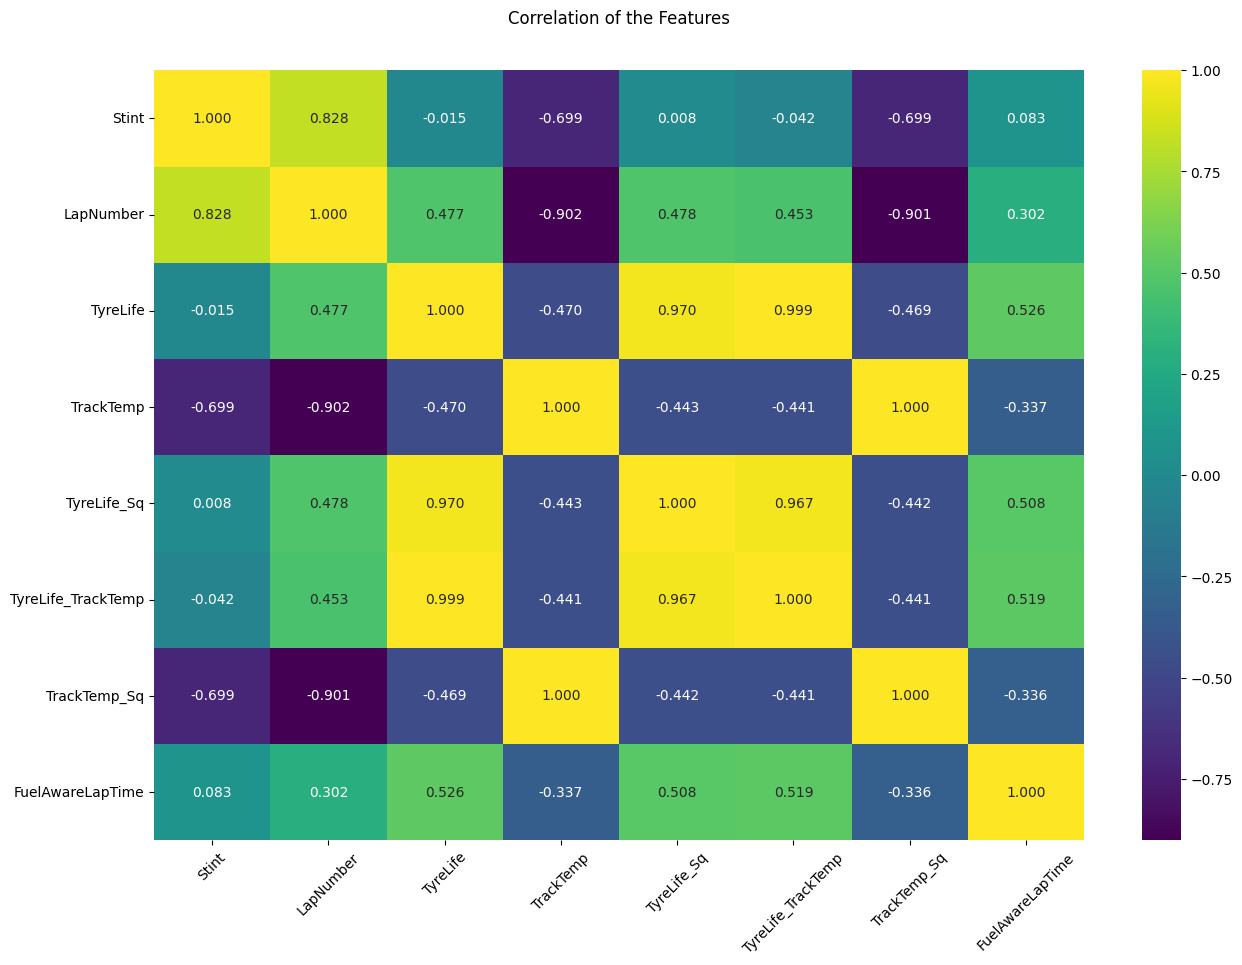

In [134]:
plt.figure(figsize=(15, 10))

corr_mat = sns.heatmap(
    data=poly_df[[*poly_df.columns[2:]]].corr(),
    cmap="viridis",
    annot=True,
    fmt=".3f"
)
corr_mat.set_title("Correlation of the Features", y=1.05)

plt.xticks(rotation=45)
plt.show()

**Important**
- While this correlation matrix is largely accurate to the data of the race it is misleading in two aspects **TrackTemp**, **TrackTemp_Sq**.
- Both these variables have a small negative correlation (0.335 ~ each) wrt **FuelAwareLapTime** which informs the pace. However, this inverse relationship contradicts conventional belief that Pace increase (Slower) with increased Temperature.
- This is however, due to the fact that during this race the Track Temp although bi-polar (visualised above) was decreasing towards the end of the race while the pace was however, slowing down in the second stint (in race-trim) as majority of the drivers were on Hard tyres thus managing the pace with access to lower grip.
- Whereas, in the first stint majority of the drivers were on Mediums which was the faster compound (higher grip) and had relatively low deg across drivers (modelled below) thus allowing for faster pace despite the higher temperature.
- This is hence reflected in the correlation matrix which doesn't show the true reason for this contradiction.

In [137]:
driver_deg_coeffs = []

# Grouping the drivers for the new polynomial features
grouped_driver_df = poly_df.groupby(["Driver", "Stint"])

# Iterating through the drivers to the model features
for driver_info, stint_data in grouped_driver_df:
    model = RandomForestRegressor(criterion="squared_error")
    model.fit(
        X=stint_data[["Stint", "LapNumber", "TyreLife", "TyreLife_Sq", "TrackTemp", "TrackTemp_Sq", "TyreLife_TrackTemp"]],
        y=stint_data["FuelAwareLapTime"]
    )

    # Modelled Coefficients for each driver for each stint
    coeffs = model.feature_importances_

    # Appending the data for a DataFrame
    driver_deg_coeffs.append([driver_info[0], driver_info[1], *list(coeffs)])

# Constructing the DataFrame
driver_deg_df = pd.DataFrame(
    data=driver_deg_coeffs,
    columns=[
        "Driver", "Stint", "W_Stint", "W_LapNumber", "W_TyreLife", 
        "W_Tyrelife_Sq", "W_TrackTemp", "W_TrackTemp_Sq", "W_TyreLife_TrackTemp"
    ]
)

driver_deg_df

,Driver,Stint,W_Stint,W_LapNumber,W_TyreLife,W_Tyrelife_Sq,W_TrackTemp,W_TrackTemp_Sq,W_TyreLife_TrackTemp
0,LEC,1.0,0.0,0.227704,0.234462,0.255247,0.029375,0.039598,0.213613
1,LEC,2.0,0.0,0.230088,0.177608,0.212198,0.086124,0.121608,0.172374
2,NOR,1.0,0.0,0.214788,0.191659,0.247818,0.084290,0.073176,0.188270
3,NOR,2.0,0.0,0.167604,0.116974,0.164303,0.214053,0.191227,0.145839
4,PIA,1.0,0.0,0.245981,0.155905,0.208740,0.050146,0.089430,0.249797
5,PIA,2.0,0.0,0.277247,0.215968,0.198840,0.056897,0.076664,0.174384
6,RUS,1.0,0.0,0.216652,0.193466,0.231123,0.145401,0.082791,0.130568
7,RUS,2.0,0.0,0.269616,0.243524,0.206996,0.032315,0.032607,0.214941
8,VER,1.0,0.0,0.194270,0.159977,0.211337,0.120947,0.141935,0.171534
9,VER,2.0,0.0,0.216498,0.229547,0.164332,0.106842,0.076670,0.206111


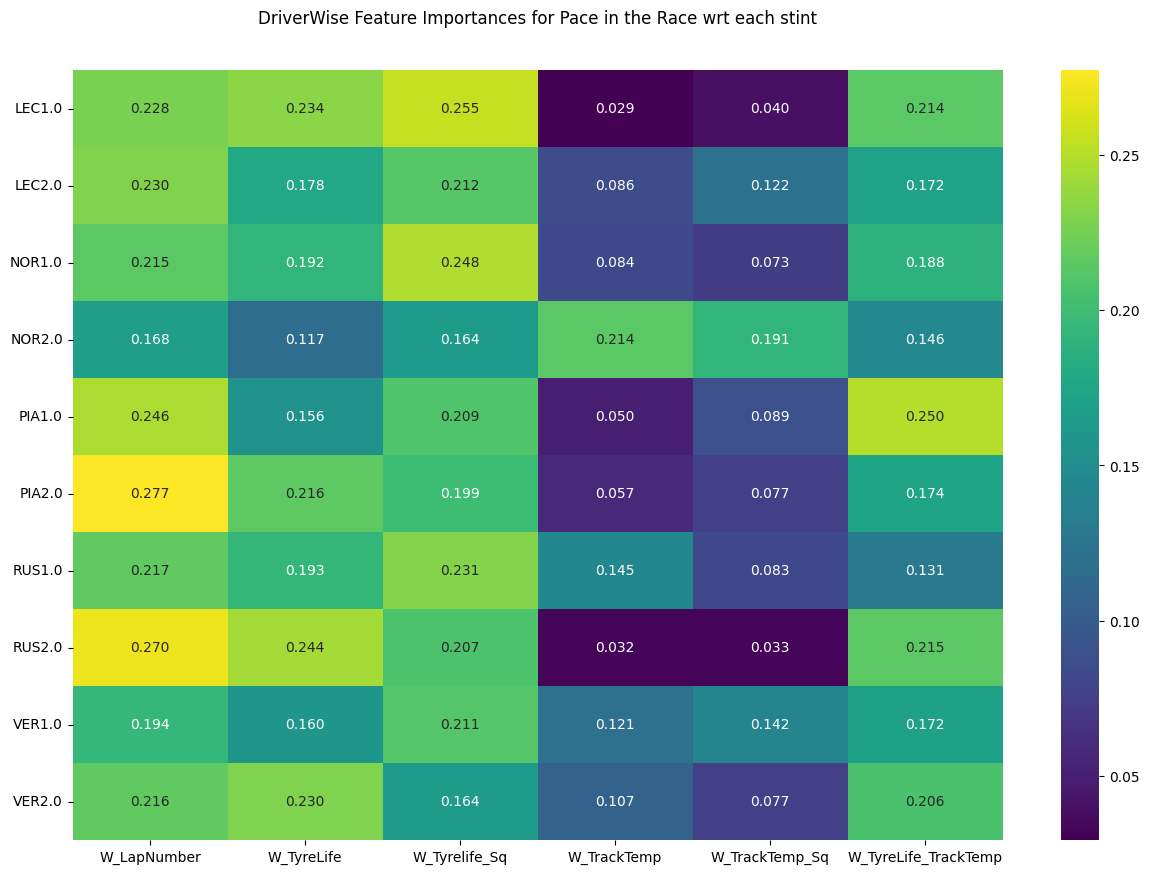

In [138]:
plt.figure(figsize=(15, 10))

feat_mat = sns.heatmap(
    data=driver_deg_df[[*driver_deg_df.columns[3:]]],
    cmap="viridis",
    annot=True,
    fmt=".3f"
)

feat_mat.set_title("DriverWise Feature Importances for Pace in the Race wrt each stint", y=1.05)
feat_mat.set_yticklabels(
    labels=driver_deg_df["Driver"] + driver_deg_df["Stint"].astype(str)
)

plt.yticks(rotation=0)
plt.show()

In [ ]:
# Norris's Consistency
race_laps[
    ((race_laps["Position"] == 4.0) | (race_laps["Position"] == 5.0)) &
    (race_laps["Stint"] == 2.0) &
    (race_laps["LapNumber"] > 34)
][battle_cols]

,LapNumber,Driver,DriverNumber,LapTime,Stint,Sector1Time,SpeedI1,Sector2Time,SpeedI2,Sector3Time,SpeedST,TyreLife,Position,Compound
134,35.0,LEC,16,92.390,2.0,34.030,293.0,29.051,313.0,29.309,318.0,6.0,4.0,HARD
135,36.0,LEC,16,92.738,2.0,34.189,292.0,29.044,310.0,29.505,314.0,7.0,4.0,HARD
136,37.0,LEC,16,92.273,2.0,34.166,291.0,28.994,324.0,29.113,329.0,8.0,4.0,HARD
184,35.0,NOR,4,109.867,2.0,50.942,290.0,29.517,300.0,29.408,301.0,1.0,5.0,MEDIUM
185,36.0,NOR,4,92.432,2.0,34.131,291.0,28.970,300.0,29.331,304.0,2.0,5.0,MEDIUM
186,37.0,NOR,4,92.130,2.0,33.931,293.0,28.947,303.0,29.252,305.0,3.0,5.0,MEDIUM
187,38.0,NOR,4,92.143,2.0,33.934,292.0,28.961,304.0,29.248,307.0,4.0,5.0,MEDIUM
188,39.0,NOR,4,92.192,2.0,33.979,293.0,29.011,305.0,29.202,307.0,5.0,5.0,MEDIUM
189,40.0,NOR,4,92.432,2.0,33.904,294.0,29.171,312.0,29.357,326.0,6.0,5.0,MEDIUM
190,41.0,NOR,4,91.778,2.0,33.499,291.0,28.943,305.0,29.336,305.0,7.0,4.0,MEDIUM


In [76]:
# Verstappen Cutting through the Front Pack
race_laps[
    (race_laps["Driver"] == "VER") &
    (race_laps["Stint"] == 2.0)
][battle_cols]

,LapNumber,Driver,DriverNumber,LapTime,Stint,Sector1Time,SpeedI1,Sector2Time,SpeedI2,Sector3Time,SpeedST,TyreLife,Position,Compound
71,22.0,VER,1,115.832,2.0,56.930,286.0,29.397,299.0,29.505,305.0,1.0,5.0,HARD
72,23.0,VER,1,94.112,2.0,34.724,290.0,29.760,306.0,29.628,325.0,2.0,4.0,HARD
73,24.0,VER,1,93.419,2.0,34.440,288.0,29.354,299.0,29.625,304.0,3.0,4.0,HARD
74,25.0,VER,1,93.067,2.0,34.230,289.0,29.304,301.0,29.533,306.0,4.0,4.0,HARD
75,26.0,VER,1,93.020,2.0,34.232,290.0,29.277,301.0,29.511,306.0,5.0,4.0,HARD
76,27.0,VER,1,92.936,2.0,34.098,289.0,29.286,303.0,29.552,308.0,6.0,4.0,HARD
77,28.0,VER,1,92.958,2.0,34.049,290.0,29.316,300.0,29.593,307.0,7.0,4.0,HARD
78,29.0,VER,1,93.079,2.0,34.175,NaN,29.277,302.0,29.627,307.0,8.0,4.0,HARD
79,30.0,VER,1,92.811,2.0,34.059,NaN,29.254,301.0,29.498,307.0,9.0,3.0,HARD
80,31.0,VER,1,92.782,2.0,34.034,NaN,29.188,301.0,29.560,307.0,10.0,3.0,HARD


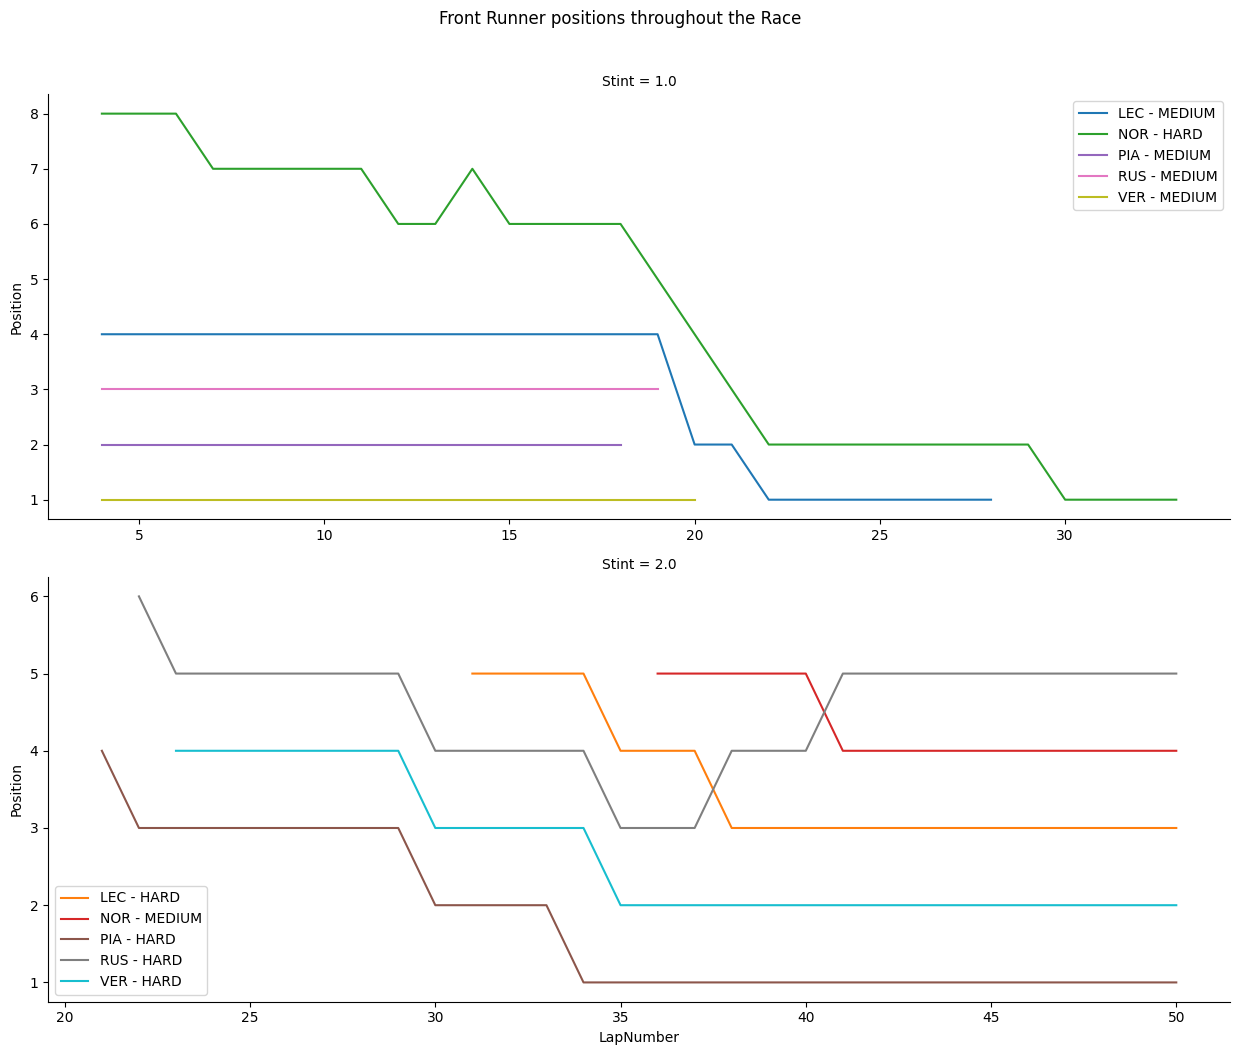

In [77]:
position_grid = sns.FacetGrid(
    data=weather_aware_race_df,
    row="Stint",
    hue="DriverCompoundForStint",
    sharex=False,
    sharey=False,
    height=5,
    aspect=2.5
)

position_grid.map_dataframe(
    sns.lineplot,
    x="LapNumber",
    y="Position"
)

for ax in position_grid.axes.flatten():
    ax.legend()

position_grid.figure.suptitle("Front Runner positions throughout the Race", y=1.05)
plt.show()

## Fin!!
Cheers for the read 🙂